In [374]:
# basic python data handling analysis modules
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set()
sns.palplot(sns.color_palette("colorblind"))
# https://medium.com/@neuralnets/data-visualization-with-python-and-seaborn-part-3-69647c19bf2
import pickle, os, gc, re
# small utility functions
from utility import *

# interactive jupyter widgets!
# https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

In [3]:
Dataset_directory = ".."+os.sep+"Datasets"+os.sep

In [4]:
INT_df = pd.read_msgpack(Dataset_directory+"Processed"+os.sep+"INT_df_with_aggregate"+".msgpack")
tv_series_mislabelled_as_a_movie = INT_df[INT_df["TMB_tv_not_film"]==1].index
INT_df.drop(tv_series_mislabelled_as_a_movie,inplace=True)

In [5]:
INT_df_ord_only = pd.read_msgpack(Dataset_directory+"Processed"+os.sep+"INT_df_ord_only"+".msgpack")

In [296]:
%%time
# I wonder if MovieLens would like to pay me for fixing their data?
INT_df.loc[8688,"SER_releaseDate"] = "1968-12-13" # Shalako 13 December 1968
INT_df.loc[33471,"SER_releaseDate"] = "2002-04-05" # https://www.imdb.com/title/tt0292553/?ref_=fn_al_tt_1
INT_df.loc[46121,"SER_releaseDate"] = "2001-06-01" # https://www.imdb.com/title/tt0135024/releaseinfo?ref_=tt_dt_dt
INT_df.loc[47991,"SER_releaseDate"] = "2005-06-09" # https://www.imdb.com/title/tt0383304/releaseinfo?ref_=tt_dt_dt
INT_df.loc[42941,"SER_releaseDate"] = "1974-08-08" # https://www.imdb.com/title/tt0071840/releaseinfo?ref_=tt_dt_dt
INT_df.loc[59300,"SER_releaseDate"] = "1986-09-12" # https://www.imdb.com/title/tt0090678/releaseinfo?ref_=tt_dt_dt
INT_df.loc[55631,"SER_releaseDate"] = "2006-03-17" # https://www.imdb.com/title/tt0443446/releaseinfo?ref_=tt_dt_dt
INT_df.loc[60034,"SER_releaseDate"] = "2007-01-22" # https://www.imdb.com/title/tt0893331/releaseinfo?ref_=tt_dt_dt
INT_df.loc[97703,"SER_releaseDate"] = "2012-05-07" # https://www.imdb.com/title/tt2209386/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105159,"SER_releaseDate"] = "2012-07-13" # https://www.imdb.com/title/tt1859446/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105453,"SER_releaseDate"] = "2013-09-19" # https://www.imdb.com/title/tt2717558/releaseinfo?ref_=tt_dt_dt
INT_df.loc[105855,"SER_releaseDate"] = "2013-10-11" # https://www.imdb.com/title/tt2286990/releaseinfo?ref_=tt_dt_dt
INT_df.loc[109455,"SER_releaseDate"] = "2014-02-21" # https://www.imdb.com/title/tt2980794/releaseinfo?ref_=tt_dt_dt
INT_df.loc[57486,"SER_releaseDate"] = "1970-10-23" # https://www.imdb.com/title/tt0066578/releaseinfo?ref_=tt_dt_dt
INT_df.loc[53502,"SER_releaseDate"] = "1948-04-27" # https://www.imdb.com/title/tt0040098/releaseinfo?ref_=tt_dt_dt
INT_df.loc[60049,"SER_releaseDate"] = "2007-05-30" # https://www.imdb.com/title/tt0832937/releaseinfo?ref_=tt_dt_dt

INT_df["SER_releaseDate"] = pd.to_datetime(INT_df["SER_releaseDate"].replace("0000-00-00",np.nan)).apply(lambda x: x.date())
## another problem - whole load of SER_releaseDates *just happen* to be the UNIX start date -> statistically improbable
# (yes, I checked whether it happened to be the data of a film festival - it was not!)
# also, more on one single date by an order of magnitude
matching_UNIX_start_date = INT_df["SER_releaseDate"]==pd.to_datetime("1969-12-31").date()
INT_df.loc[matching_UNIX_start_date,"SER_releaseDate"] = np.datetime64('NaT')

INT_df["SER_release_year"]  = INT_df["SER_releaseDate"].apply(lambda x: x.year)
INT_df["SER_release_month"] = INT_df["SER_releaseDate"].apply(lambda x: x.month)
INT_df["SER_release_day"]   = INT_df["SER_releaseDate"].apply(lambda x: x.day)


date_vars = ["TMB_release_date","SER_releaseDate"]
# hardfix SER and TMB, NUM_date looks fine
dates = INT_df[date_vars].applymap(lambda x: pd.to_datetime(x).date())
placeholder_month_day = dates.applymap(lambda x: (x.day==1) & (x.month==1) if pd.notnull(x) else np.nan)

INT_df.loc[ placeholder_month_day["TMB_release_date"]==True , "TMB_release_month" ] = np.nan
INT_df.loc[ placeholder_month_day["TMB_release_date"]==True , "TMB_release_day"   ] = np.nan

# Meh - no perfect solution - still waaay too many 1st of the month dates ...
# But we don't have enough data in NUM_date to compensate if you just toss them all out

# INT_df.loc[ INT_df["TMB_release_day"]==1 , "TMB_release_day"   ] = np.nan

INT_df.loc[ placeholder_month_day["SER_releaseDate" ]==True , "SER_release_month" ] = np.nan
INT_df.loc[ placeholder_month_day["SER_releaseDate" ]==True , "SER_release_day"   ] = np.nan
# INT_df.loc[ INT_df["SER_release_day"]==1 , "SER_release_day"   ] = np.nan


# this represents a very informal sensse of which source is most authoritative!
# TMB user content - least reliable, NUM website focused on accurate
# HETREC and SER are MovieLens data - not bad, but maybe not so well checked (HETREC in particular has problems)

# Concerned that HETREC is really very dodgy

release_date = INT_df[["TMB_release_date","SER_releaseDate","NUM_date"]].fillna(method="ffill",axis=1)["NUM_date"]
release_date = pd.to_datetime(release_date)




INT_df["release_year"] = INT_df[['HETREC_year','TMB_release_year','SER_release_year','NUM_release_year']].fillna(method="ffill",axis=1)["NUM_release_year"]

INT_df["release_month"] = INT_df[['TMB_release_month','SER_release_month','NUM_release_month']].fillna(method="ffill",axis=1)["NUM_release_month"]

INT_df["release_day"] = INT_df[['TMB_release_day','SER_release_day','NUM_release_day']].fillna(method="ffill",axis=1)["NUM_release_day"]



Wall time: 30.3 s


In [393]:
object_cols = INT_df.columns[INT_df.dtypes =="object"]
object_cols
# HETREC_country
# HETREC_directorName
# SER_directedBy
# SER_starring
# SER_genres
# SER_director_list
# SER_genres_list
# SER_starring_list
# ML_genres

# Maybe something cautionary about how well the titles match? A hint about which data might not be so reliable?
# gender balance/crew/cast breakdown by order


# DONE
# Films per year!
# Months/days/weekdays dummied up!


Index(['TMB_homepage', 'TMB_original_title', 'TMB_overview', 'TMB_poster_path',
       'TMB_production_companies', 'TMB_production_countries',
       'TMB_release_date', 'TMB_spoken_languages', 'TMB_status', 'TMB_tagline',
       'TMB_title', 'TMB_keyword_id_list', 'TMB_cast_list', 'TMB_crew_list',
       'HETREC_title', 'HETREC_spanishTitle', 'HETREC_imdbPictureURL',
       'HETREC_rtID', 'HETREC_rtPictureURL', 'HETREC_country',
       'HETREC_directorID', 'HETREC_directorName', 'SER_title',
       'SER_releaseDate', 'SER_directedBy', 'SER_starring', 'SER_genres',
       'SER_director_list', 'SER_genres_list', 'SER_starring_list', 'ML_title',
       'ML_genres', 'NUM_date', 'NUM_title', 'NUM_link'],
      dtype='object')

In [ ]:
# * Integrate genre variables 
# * Look at # HETREC_country/# HETREC_directorName/# SER_directedBy/# SER_starring

TMB_genres_Adventure          45354
TMB_genres_Fantasy            45354
TMB_genres_Animation          45354
TMB_genres_Drama              45354
TMB_genres_Horror             45354
TMB_genres_Action             45354
TMB_genres_Comedy             45354
TMB_genres_History            45354
TMB_genres_Western            45354
TMB_genres_Thriller           45354
TMB_genres_Crime              45354
TMB_genres_Documentary        45354
TMB_genres_Science Fiction    45354
TMB_genres_Mystery            45354
TMB_genres_Music              45354
TMB_genres_Romance            45354
TMB_genres_Family             45354
TMB_genres_War                45354
TMB_genres_Foreign            45354
TMB_genres_TV Movie           45354
dtype: int64

In [395]:
INT_df[["SER_genres","SER_genres_list","ML_genres"]]

SER_genres  \
movieId                                                
1        Adventure,Animation,Children,Comedy,Fantasy   
2                         Adventure,Children,Fantasy   
3                                     Comedy,Romance   
4                               Comedy,Drama,Romance   
5                                             Comedy   
6                              Action,Crime,Thriller   
7                                     Comedy,Romance   
8                                 Adventure,Children   
9                                             Action   
10                         Action,Adventure,Thriller   
11                              Comedy,Drama,Romance   
12                                     Comedy,Horror   
13                      Adventure,Animation,Children   
14                                             Drama   
15                          Action,Adventure,Romance   
16                                       Crime,Drama   
17                                     Drama,Romance   
18                                            Comedy   
19                                            Comedy   
20                Action,Comedy,Crime,Drama,Thriller   
21                             Comedy,Crime,Thriller   
22               Crime,Drama,Horror,Mystery,Thriller   
23                             Action,Crime,Thriller   
24                                      Drama,Sci-Fi   
25                                     Drama,Romance   
26                                             Drama   
27                                    Children,Drama   
28                                     Drama,Romance   
29            Adventure,Drama,Fantasy,Mystery,Sci-Fi   
30                                       Crime,Drama   
...                                              ...   
193807                                           NaN   
193809                                           NaN   
193811                                           NaN   
193815                                           NaN   
193817                                           NaN   
193819                                           NaN   
193823                                           NaN   
193825                                           NaN   
193827                                           NaN   
193829                                           NaN   
193833                                           NaN   
193835                                           NaN   
193839                                           NaN   
193841                                           NaN   
193843                                           NaN   
193845                                           NaN   
193849                                           NaN   
193853                                           NaN   
193855                                           NaN   
193857                                           NaN   
193866                                           NaN   
193868                                           NaN   
193870                                           NaN   
193872                                           NaN   
193874                                           NaN   
193876                                           NaN   
193878                                           NaN   
193880                                           NaN   
193882                                           NaN   
193886                                           NaN   

                                                     SER_genres_list  \
movieId                                                                
1        ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']   
2                               ['Adventure', 'Children', 'Fantasy']   
3                                              ['Comedy', 'Romance']   
4                                     ['Comedy', 'Drama', 'Romance']   
5                                                         ['Comedy']   
6        

In [408]:
INT_df["SER_genres_list"].dropna().apply(lambda x: eval(x))

movieId
1         [Adventure, Animation, Children, Comedy, Fantasy]
2                            [Adventure, Children, Fantasy]
3                                         [Comedy, Romance]
4                                  [Comedy, Drama, Romance]
5                                                  [Comedy]
6                                 [Action, Crime, Thriller]
7                                         [Comedy, Romance]
8                                     [Adventure, Children]
9                                                  [Action]
10                            [Action, Adventure, Thriller]
11                                 [Comedy, Drama, Romance]
12                                         [Comedy, Horror]
13                         [Adventure, Animation, Children]
14                                                  [Drama]
15                             [Action, Adventure, Romance]
16                                           [Crime, Drama]
17                              

In [400]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [412]:
SER_genre_set = list(set(flatten(INT_df["SER_genres_list"].dropna().apply(lambda x: eval(x)))))
SER_genre_set

['Mystery',
 'Adventure',
 'Animation',
 'Action',
 'Western',
 'Drama',
 'Children',
 'Crime',
 'Horror',
 'Thriller',
 'Romance',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'Film-Noir',
 'Fantasy',
 'Musical',
 'Comedy',
 'War']

In [414]:
ML_genre_set = list(set(flatten(INT_df["ML_genres"].dropna().apply(lambda x: x.split("|")))))
ML_genre_set

['Mystery',
 'Adventure',
 'Animation',
 'Action',
 'Western',
 'Drama',
 'Children',
 'Crime',
 'Horror',
 'Thriller',
 'Romance',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'Film-Noir',
 '(no genres listed)',
 'Fantasy',
 'Musical',
 'Comedy',
 'War']

In [419]:
flat_list

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Adventure',
 'Children',
 'Fantasy',
 'Comedy',
 'Romance',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Romance',
 'Adventure',
 'Children',
 'Action',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Horror',
 'Adventure',
 'Animation',
 'Children',
 'Drama',
 'Action',
 'Adventure',
 'Romance',
 'Crime',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Crime',
 'Thriller',
 'Crime',
 'Drama',
 'Horror',
 'Mystery',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Drama',
 'Sci-Fi',
 'Drama',
 'Romance',
 'Drama',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Adventure',
 'Drama',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Crime',
 'Drama',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Adventure',
 'Romance',
 'IMAX',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Crime',
 'Drama',
 'Documentary',
 'IMAX',
 'Children',
 'Comedy',
 'Comedy',
 'Romance',
 'Drama',
 'Drama',
 'War',
 'Action',
 'Crime',
 'Drama',
 'Drama',
 'Action',
 'Adventure',
 'Fantasy',
 'Comedy',
 'Drama',
 'Thriller',
 'Drama',
 'Romance',
 'Mystery',
 'Thriller',
 'Animation',
 'Children',
 'Drama',
 'Musical',
 'Romance',
 'Drama',
 'Romance',
 'Crime',
 'Mystery',
 'Thriller',
 'Action',
 'Drama',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Adventure',
 'Drama',
 'Children',
 'Comedy',
 'Drama',
 'Adventure',
 'Children',
 'Comedy',
 'Fantasy',
 'Drama',
 'Comedy',
 'Drama',
 'Romance',
 'Drama',
 'Mystery',
 'Adventure',
 'Children',
 'Fantasy',
 'Drama',
 'Thriller',
 'Drama',
 'Comedy',
 'Crime',
 'Comedy',
 'Romance',
 'Comedy',
 'Action',
 'Sci-Fi',
 'Thriller',
 'Drama',
 'Comedy',
 'Romance',
 'Comedy',
 'Action',
 'Comedy',
 'Horror',
 'Thriller',
 'Action',
 'Comedy',
 'Drama',
 'Drama',
 'War',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Action',
 'Sci-Fi',
 'Thriller',
 'Documentary',
 'Action',
 'Crime',
 'Drama',
 'Thriller',
 'Drama',
 'Thriller',
 'Children',
 'Drama',
 'Crime',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Drama',
 'Romance',
 'Action',
 'Adventure',
 'Drama',
 'Children',
 'Comedy',
 'Comedy',
 'Action',
 'Thriller',
 'Drama',
 'Drama',
 'Horror',
 'Thriller',
 'Comedy',
 'Horror',
 'Romance',
 'Comedy',
 'Drama',
 'Romance',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Drama',
 'Crime',
 'Drama',
 'Action',
 'Thriller',
 'Documentary',
 'Drama',
 'Thriller',
 'Adventure',
 'Comedy',
 'Crime',
 'Romance',
 'Comedy',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Adventure',
 'Children',
 'Comedy',
 'Musical',
 'Action',
 'Drama',
 'War',
 'Crime',
 'Drama',
 'Thriller',
 'Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Drama',
 'Mystery',
 'Drama',
 'Comedy',
 'Documentary',
 'Crime',
 'Drama',
 'Comedy',
 'Romance',
 'Comedy',
 'Adventure',
 'Comedy',
 'Drama',
 'Drama',
 'Comedy',
 'Romance',
 'Drama',
 'Mystery',
 'Romance',
 'Drama',
 'Comedy',
 'Adventure',
 'Children',
 'Fantasy',
 'Drama',
 'Documentary',
 'Comedy',
 'Romance',
 'Drama',
 'Drama',
 'Romance',
 'Thriller',
 'Comedy',
 'Drama',
 'Documentary',
 'Comedy',
 'Documentary',
 'Documentary',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Drama',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Drama',
 'Thriller',
 'Adventure',
 'Children',
 'Drama',
 'Drama',
 'Crime',
 'Drama',
 'Thriller',
 'Adventure',
 'Drama',
 'IMAX',
 'Action',
 'Drama',
 'Romance',
 'War',
 'Drama',
 'Horror',
 'Action',
 'Adventure',
 'Comedy',
 'Crime',
 'Drama',
 'Adventure',
 'Drama',
 'War',
 'Comedy',
 'Drama',
 'Comedy',
 'War',
 'Adventure',
 'Children',
 'Crime',
 'Drama',
 'Mystery',
 'Action',
 'Adventure',
 'Mystery',
 'Sci-Fi',
 'Drama',
 'Thriller',
 'War',
 'Documentary',
 'Action',
 'Romance',
 'Western',
 'Crime',
 'Film-Noir',
 'Mystery',
 'Thriller',
 'Act

In [487]:
INT_df["SER_genres_list"] = INT_df["SER_genres_list"].apply(lambda x: eval(x) if pd.notnull(x) else np.nan)
flat_list = [item for sublist in INT_df["SER_genres_list"].dropna().values for item in sublist]
genres = pd.DataFrame(flat_list).drop_duplicates()#.sort_values(by="movieId")

for gen_ind in genres.index:
    gen_name = "SER_genres_"+genres.loc[gen_ind,0]
    INT_df[gen_name] = INT_df["SER_genres_list"].apply(lambda x: genres.loc[gen_ind,0] in x if isinstance(x,list) or pd.notnull(x) else np.nan)

SER_genre_vars = search(INT_df,"SER_genres_[A-Z]",case_sensitive=True)
SER_genre_vars

SER_genres_Adventure      45797
SER_genres_Animation      45797
SER_genres_Children       45797
SER_genres_Comedy         45797
SER_genres_Fantasy        45797
SER_genres_Romance        45797
SER_genres_Drama          45797
SER_genres_Action         45797
SER_genres_Crime          45797
SER_genres_Thriller       45797
SER_genres_Horror         45797
SER_genres_Mystery        45797
SER_genres_Sci-Fi         45797
SER_genres_IMAX           45797
SER_genres_Documentary    45797
SER_genres_War            45797
SER_genres_Musical        45797
SER_genres_Western        45797
SER_genres_Film-Noir      45797
dtype: int64

In [488]:
INT_df["ML_genres_list"] = INT_df["ML_genres"].apply(lambda x: x.split("|") if pd.notnull(x) else np.nan)
flat_list = [item for sublist in INT_df["ML_genres_list"].dropna().values for item in sublist]
genres = pd.DataFrame(flat_list).drop_duplicates()#.sort_values(by="movieId")

for gen_ind in genres.drop(34364).index:
    gen_name = "ML_genres_"+genres.loc[gen_ind,0]
    INT_df[gen_name] = INT_df["ML_genres_list"].apply(lambda x: genres.loc[gen_ind,0] in x if isinstance(x,list) or pd.notnull(x) else False)
    
ML_genre_vars = search(INT_df,"ML_genres_[A-Z]",case_sensitive=True)
ML_genre_vars
    

ML_genres_Adventure      59324
ML_genres_Animation      59324
ML_genres_Children       59324
ML_genres_Comedy         59324
ML_genres_Fantasy        59324
ML_genres_Romance        59324
ML_genres_Drama          59324
ML_genres_Action         59324
ML_genres_Crime          59324
ML_genres_Thriller       59324
ML_genres_Horror         59324
ML_genres_Mystery        59324
ML_genres_Sci-Fi         59324
ML_genres_IMAX           59324
ML_genres_Documentary    59324
ML_genres_War            59324
ML_genres_Musical        59324
ML_genres_Western        59324
ML_genres_Film-Noir      59324
dtype: int64

In [481]:
# do ML_genres, add HETREC_genres too!


In [490]:
INT_df[SER_genre_vars.index].sum()

SER_genres_Adventure       3519.0
SER_genres_Animation       2350.0
SER_genres_Children        2382.0
SER_genres_Comedy         13759.0
SER_genres_Fantasy         2376.0
SER_genres_Romance         6322.0
SER_genres_Drama          20786.0
SER_genres_Action          6091.0
SER_genres_Crime           4445.0
SER_genres_Thriller        7114.0
SER_genres_Horror          4832.0
SER_genres_Mystery         2398.0
SER_genres_Sci-Fi          3026.0
SER_genres_IMAX             198.0
SER_genres_Documentary     4383.0
SER_genres_War             1607.0
SER_genres_Musical         1080.0
SER_genres_Western         1014.0
SER_genres_Film-Noir        364.0
dtype: float64

In [491]:
INT_df[ML_genre_vars.index].sum()

ML_genres_Adventure       4058
ML_genres_Animation       2662
ML_genres_Children        2749
ML_genres_Comedy         15953
ML_genres_Fantasy         2634
ML_genres_Romance         7405
ML_genres_Drama          24103
ML_genres_Action          7123
ML_genres_Crime           5098
ML_genres_Thriller        8211
ML_genres_Horror          5553
ML_genres_Mystery         2769
ML_genres_Sci-Fi          3440
ML_genres_IMAX             197
ML_genres_Documentary     5097
ML_genres_War             1812
ML_genres_Musical         1113
ML_genres_Western         1374
ML_genres_Film-Noir        364
dtype: int64

In [493]:
TMB_genres_vars = search(INT_df,"TMB_genres_[A-Z]")
genres_corrs = INT_df[list(ML_genre_vars.index) + list(SER_genre_vars.index) + list(TMB_genres_vars.index)].astype('float').corr()

In [496]:
corrank(genres_corrs) # prints a descending list of correlation pair (Max on top)
# (SER_genres_Sci-Fi, TMB_genres_Science Fiction)

                                                 pairs      corr
681                  (ML_genres_IMAX, SER_genres_IMAX)  0.997461
495          (ML_genres_Thriller, SER_genres_Thriller)  0.995003
590            (ML_genres_Mystery, SER_genres_Mystery)  0.994708
851            (ML_genres_Western, SER_genres_Western)  0.994439
131          (ML_genres_Children, SER_genres_Children)  0.994230
543              (ML_genres_Horror, SER_genres_Horror)  0.994206
293            (ML_genres_Romance, SER_genres_Romance)  0.993200
446                (ML_genres_Crime, SER_genres_Crime)  0.992633
725    (ML_genres_Documentary, SER_genres_Documentary)  0.992540
636              (ML_genres_Sci-Fi, SER_genres_Sci-Fi)  0.992015
75         (ML_genres_Animation, SER_genres_Animation)  0.991900
891        (ML_genres_Film-Noir, SER_genres_Film-Noir)  0.991659
810            (ML_genres_Musical, SER_genres_Musical)  0.990954
240            (ML_genres_Fantasy, SER_genres_Fantasy)  0.990420
396              (ML_genr

In [298]:
# check out all the release data variables

In [299]:
# release_date.value_counts()

In [300]:
# INT_df[['TMB_release_day','SER_release_day','NUM_release_day']].mode()

In [301]:
# INT_df[['TMB_release_month','SER_release_month','NUM_release_month']].mode()

In [302]:


# 1969-12-31 ???? dodgy! UNIX start date!
    # -> chase this back, figure out which data column this is from!
    
# XXXX-01-01 -> the year is fine, day/month is not!

day_and_month_not_actually_given = (release_date.dt.day==1) & (release_date.dt.month==1)
release_date[~day_and_month_not_actually_given].value_counts().head(10) # fine other than the UNIX date!


2015-01-23    32
2013-09-06    30
2010-10-01    30
2012-10-12    30
2012-10-05    29
2011-09-23    29
2014-10-17    28
2013-10-11    28
2014-09-19    27
2014-09-05    27
Name: NUM_date, dtype: int64

In [303]:
release_decade = INT_df["release_year"].apply(lambda x: str(int(10*np.floor(x/10))) if pd.notnull(x) else np.nan)
release_decade_dummies = pd.get_dummies(release_decade , prefix = "release_decade__")

In [304]:
import calendar
from datetime import date
release_month = INT_df['release_month'].apply(lambda x: calendar.month_abbr[int(x)] if pd.notnull(x) else np.nan)
release_month[day_and_month_not_actually_given] = np.nan
release_month_dummies = pd.get_dummies(release_month , prefix = "release_month__")
release_month.value_counts()

Oct    4860
Sep    4380
Dec    3882
Nov    3877
Apr    3871
Mar    3871
Aug    3449
Jun    3406
May    3399
Feb    3178
Jan    3019
Jul    2839
Name: release_month, dtype: int64

In [305]:
# day in month
release_day = INT_df['release_day'].copy()#.apply(lambda x: calendar.month_abbr[int(x)] if pd.notnull(x) else np.nan)
release_day.loc[day_and_month_not_actually_given] = np.nan
release_day_dummies = pd.get_dummies(release_day , prefix = "release_day_of_the_month__")
# release_day_dummies.columns = release_day_dummies.columns.astype('int')
release_day.value_counts()

1.0     2784
25.0    1558
15.0    1549
10.0    1511
11.0    1495
6.0     1488
20.0    1470
22.0    1464
18.0    1456
12.0    1447
9.0     1446
13.0    1443
19.0    1428
14.0    1428
17.0    1410
24.0    1380
21.0    1380
16.0    1380
26.0    1372
23.0    1365
5.0     1352
7.0     1322
8.0     1311
27.0    1297
28.0    1288
4.0     1286
2.0     1249
3.0     1227
30.0    1186
29.0    1168
31.0     920
Name: release_day, dtype: int64

In [306]:
release_weekday = release_date.apply(lambda x: calendar.day_name[x.weekday()] if pd.notnull(x) else np.nan)
release_weekday.loc[day_and_month_not_actually_given] = np.nan
release_weekday_dummies = pd.get_dummies(release_weekday , prefix = "release_weekday__")
release_weekday.value_counts()

Friday       17288
Wednesday     6245
Thursday      5795
Saturday      4557
Tuesday       4084
Sunday        3207
Monday        2855
Name: NUM_date, dtype: int64

In [307]:
movies_by_year = INT_df.groupby("release_year")["movieId"].count()
INT_df["num_other_releases_that_year"] = INT_df["release_year"].apply(lambda x: movies_by_year[x]-1 if pd.notnull(x) else np.nan)

In [308]:
INT_df[release_weekday_dummies.columns]=release_weekday_dummies
INT_df[release_day_dummies.columns]    = release_day_dummies
INT_df[release_month_dummies.columns]  = release_month_dummies
INT_df[release_decade_dummies.columns] = release_decade_dummies

In [309]:
INT_df_ord_only[release_weekday_dummies.columns]=release_weekday_dummies
INT_df_ord_only[release_day_dummies.columns]    = release_day_dummies
INT_df_ord_only[release_month_dummies.columns]  = release_month_dummies
INT_df_ord_only[release_decade_dummies.columns] = release_decade_dummies
INT_df_ord_only["num_other_releases_that_year"] = INT_df["release_year"].apply(lambda x: movies_by_year[x]-1 if pd.notnull(x) else np.nan)

In [336]:
### Collections

# do mostly seem to be about sequences of movies (not, say, abstract themes with different movies/all the work of one director/big set of "classic movies")


TMB_collections = pd.read_csv(Dataset_directory+"Processed"+os.sep+"TMB_collections"+".csv",index_col="Unnamed: 0")
TMB_collections.index = TMB_collections["id"]
INT_df["TMB_collection_size"]          = INT_df["TMB_collectionId"].apply(lambda x: TMB_collections.loc[int(x),"collection_size"] if pd.notnull(x) else np.nan)
INT_df_ord_only["TMB_collection_size"] = INT_df["TMB_collectionId"].apply(lambda x: TMB_collections.loc[int(x),"collection_size"] if pd.notnull(x) else np.nan)

In [338]:
search(INT_df,"_title$")

TMB_original_title                              45354
TMB_title                                       45354
TMB_original_title_differs_from_title           45354
TMB_title_used_by_num_other_movies              45354
TMB_production_companies_Working Title Films    33527
HETREC_title                                    10194
HETREC_spanishTitle                             10194
SER_title                                       49093
ML_title                                        58019
NUM_title                                        5249
dtype: int64

In [342]:
title_vars = ["TMB_original_title","TMB_title","TMB_original_title_differs_from_title",
              "TMB_title_used_by_num_other_movies","HETREC_title","HETREC_spanishTitle",
              "SER_title","ML_title","NUM_title"]

title_vars = ["TMB_title","HETREC_title","SER_title","ML_title","NUM_title"]

In [351]:
titles = INT_df[title_vars].copy()
titles["SER_title"] = titles["SER_title"].apply(lambda x: x.split("(")[0] if pd.notnull(x) else np.nan)
titles["ML_title"] = titles["ML_title"].apply(lambda x: x.split("(")[0] if pd.notnull(x) else np.nan)
titles = titles.applymap(lambda x: x.strip().lower() if pd.notnull(x) else np.nan)

In [372]:
num_different_titles = titles.apply(lambda x: len(np.unique(x.dropna())) ,axis=1)

In [373]:
num_different_titles.value_counts()

1    48794
2     9311
3      739
0      466
4       14
dtype: int64

In [386]:
release_decade.value_counts()

2010    14708
2000    11851
1990     5909
1980     4178
1970     3802
1960     2801
1950     2212
1940     1645
1930     1453
1920      452
1910      198
1900      110
1890       85
1880        6
2020        3
1870        2
Name: release_year, dtype: int64

In [381]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

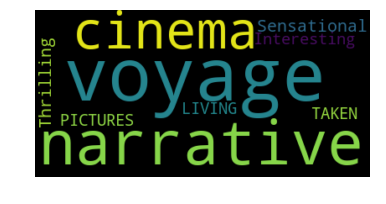

In [388]:
# 1900s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1900"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

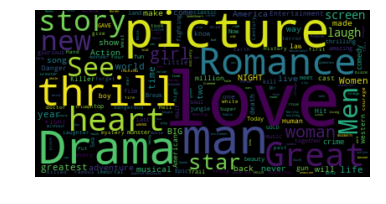

In [391]:
# 1930s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1930"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

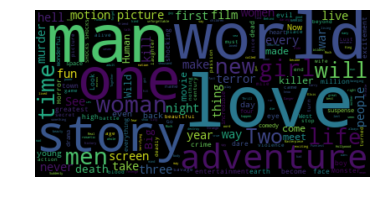

In [390]:
# 1960s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1960"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

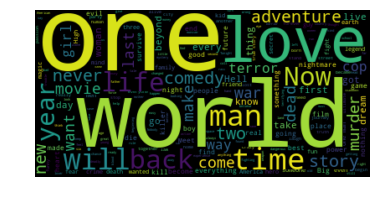

In [392]:
# 1980s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="1980"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

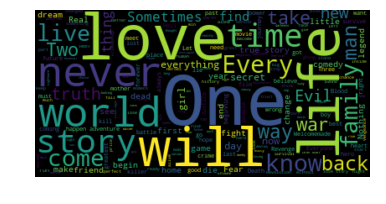

In [389]:
# 2010s taglines
wordcloud = WordCloud().generate(" ".join(INT_df["TMB_tagline"][release_decade=="2010"].dropna()))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:26:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09759
Will train until validation_0-rmse hasn't improved in 11.100000000000001 rounds.
[1]	validation_0-rmse:1.07396
[2]	validation_0-rmse:1.05141
[3]	validation_0-rmse:1.03092
[4]	validation_0-rmse:1.01221
[5]	validation_0-rmse:0.9931
[6]	validation_0-rmse:0.977547
[7]	validation_0-rmse:0.960904
[8]	validation_0-rmse:0.946336
[9]	validation_0-rmse:0.932304
[10]	validation_0-rmse:0.917965
[11]	validation_0-rmse:0.905523
[12]	validation_0-rmse:0.893745
[13]	validation_0-rmse:0.884056
[14]	validation_0-rmse:0.873205
[15]	validation_0-rmse:0.864134
[16]	validation_0-rmse:0.854295
[17]	validation_0-rmse:0.845616
[18]	validation_0-rmse:0.837064
[19]	validation_0-rmse:0.828552
[20]	validation_0-rmse:0.820892
[21]	validation_0-rmse:0.814162
[22]	validation_0-rmse:0.808829
[23]	validation_0-rmse:0.80219
[24]	

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:29:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


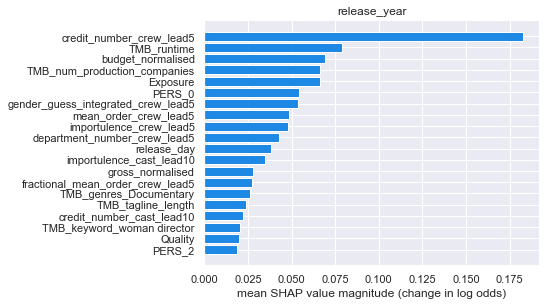

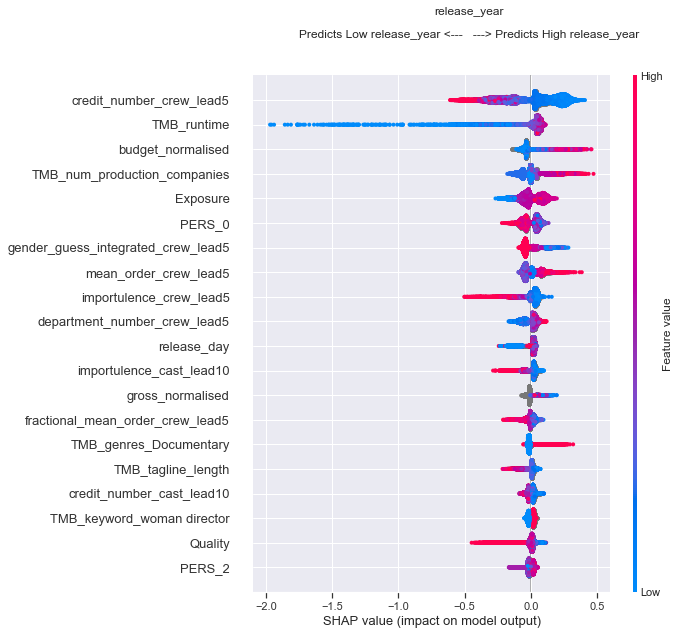

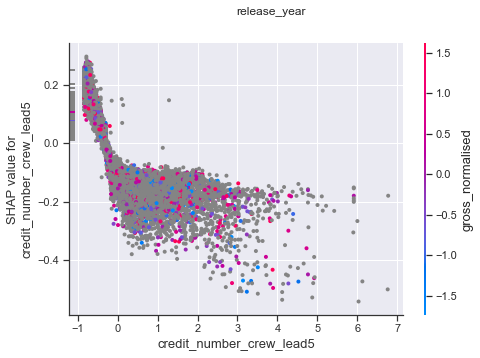

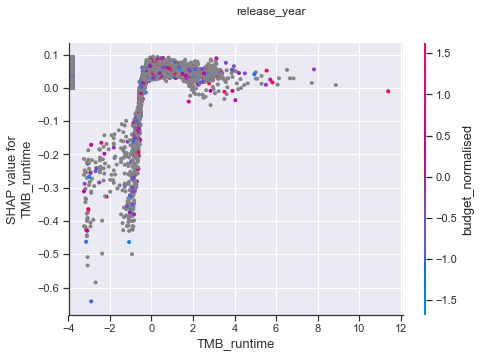

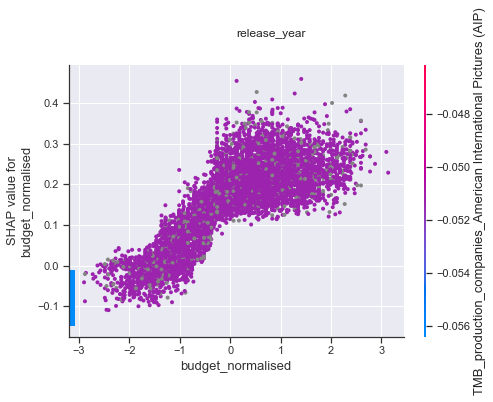

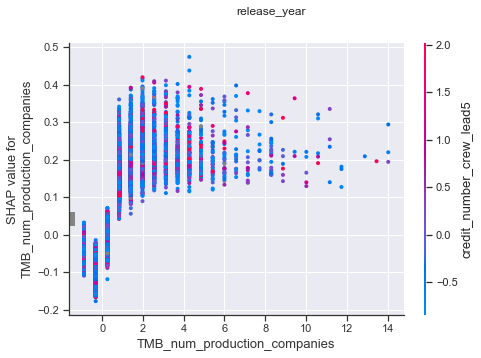

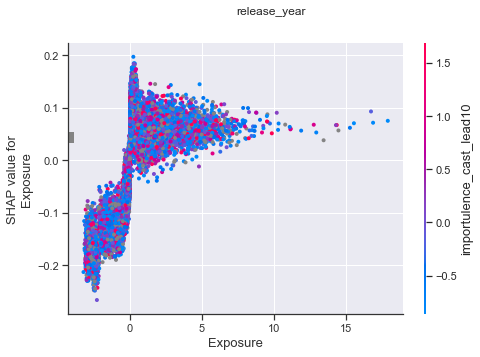

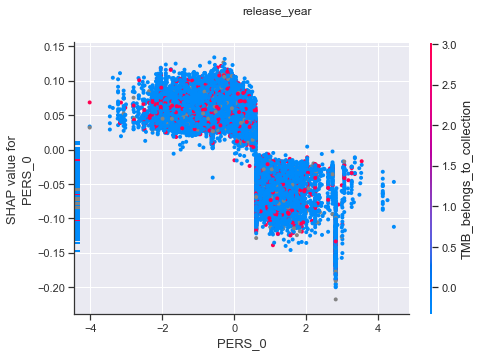

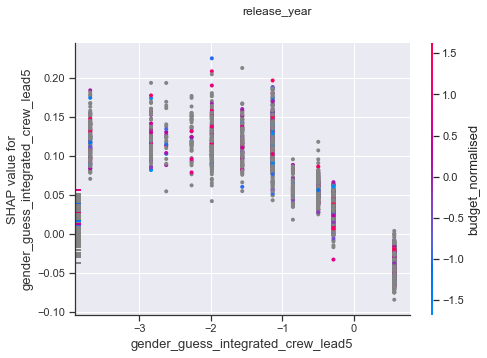

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


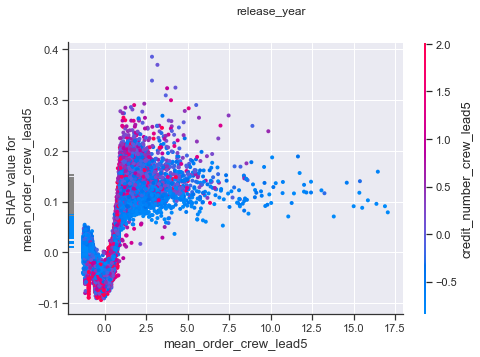

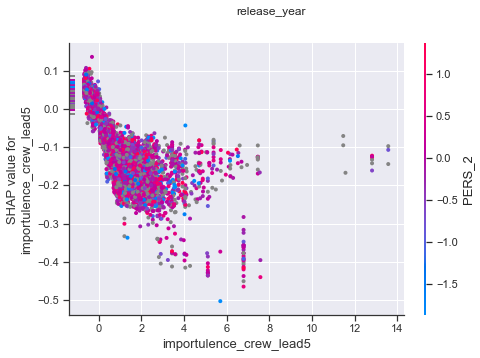

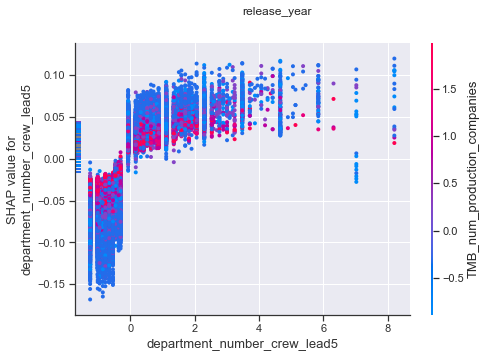

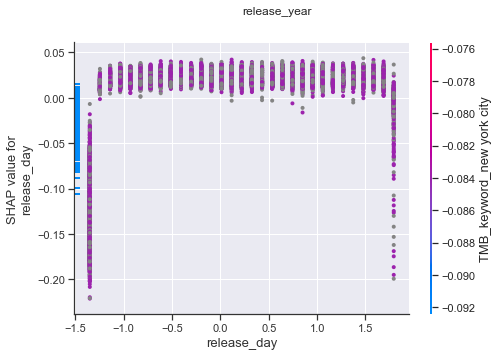

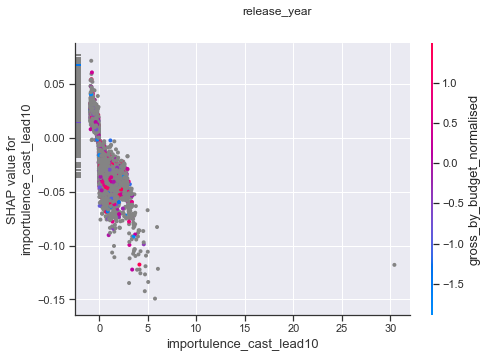

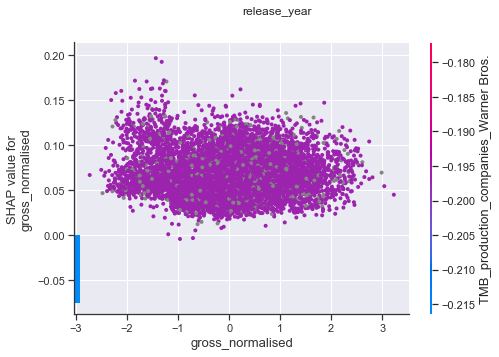

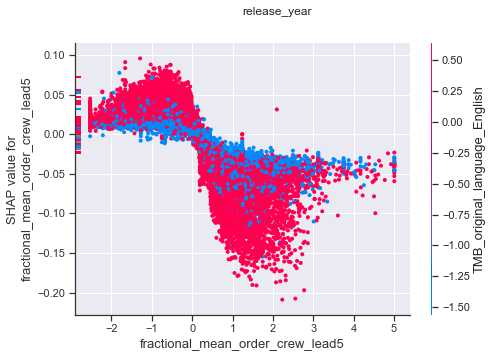

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


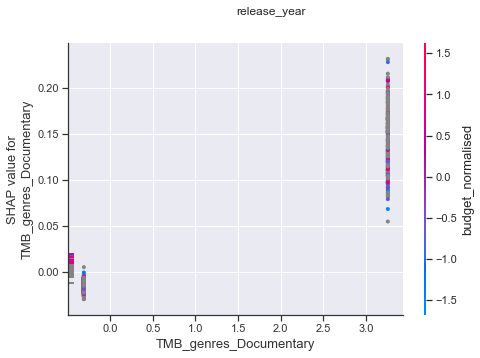

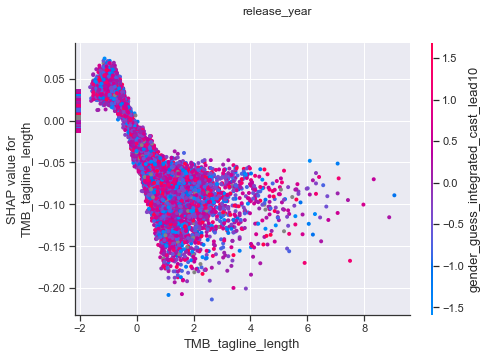

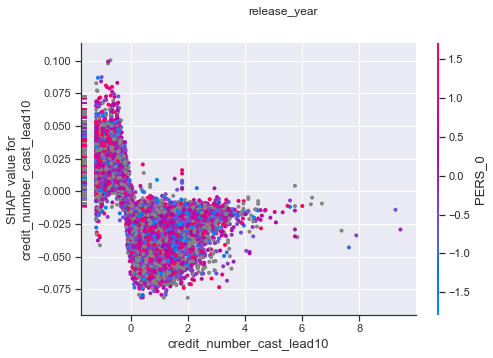

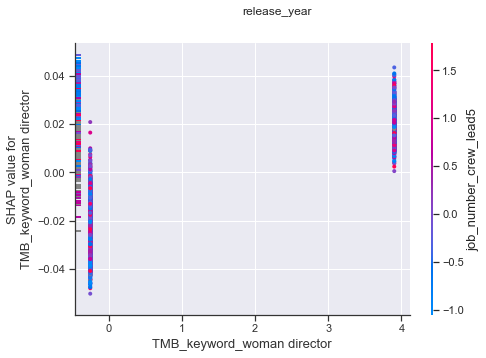

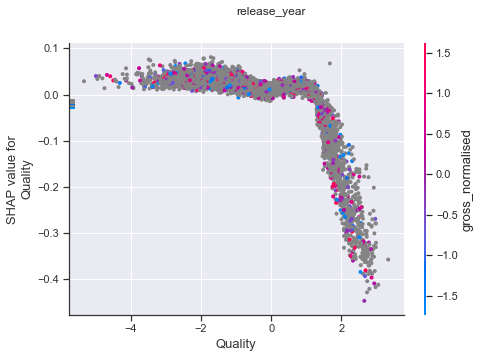

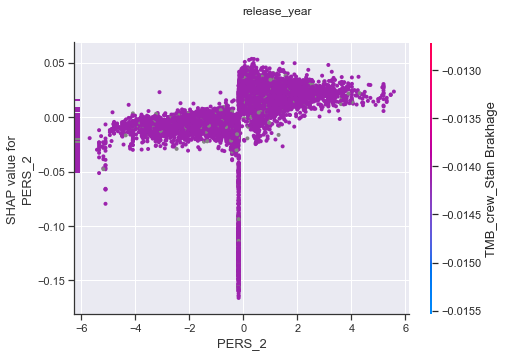

Wall time: 21min 34s


In [310]:
%%time
global BES_output_folder
drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

drop_cols.extend(list(release_decade_dummies.columns))
drop_cols.extend(["num_other_releases_that_year","TMB_num_other_movies_with_same_homepage"])

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
var_name = "release_year"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)


Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:11:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10048
Will train until validation_0-rmse hasn't improved in 9.600000000000001 rounds.
[1]	validation_0-rmse:1.07814
[2]	validation_0-rmse:1.05868
[3]	validation_0-rmse:1.03916
[4]	validation_0-rmse:1.02079
[5]	validation_0-rmse:1.00476
[6]	validation_0-rmse:0.989733
[7]	validation_0-rmse:0.97691
[8]	validation_0-rmse:0.964772
[9]	validation_0-rmse:0.951855
[10]	validation_0-rmse:0.940675
[11]	validation_0-rmse:0.928652
[12]	validation_0-rmse:0.919469
[13]	validation_0-rmse:0.909536
[14]	validation_0-rmse:0.901882
[15]	validation_0-rmse:0.894417
[16]	validation_0-rmse:0.88765
[17]	validation_0-rmse:0.880405
[18]	validation_0-rmse:0.874346
[19]	validation_0-rmse:0.868761
[20]	validation_0-rmse:0.862158
[21]	validation_0-rmse:0.856038
[22]	validation_0-rmse:0.850327
[23]	validation_0-rmse:0.845279
[24]	v

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:11:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


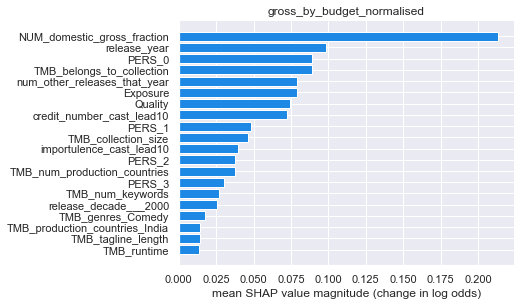

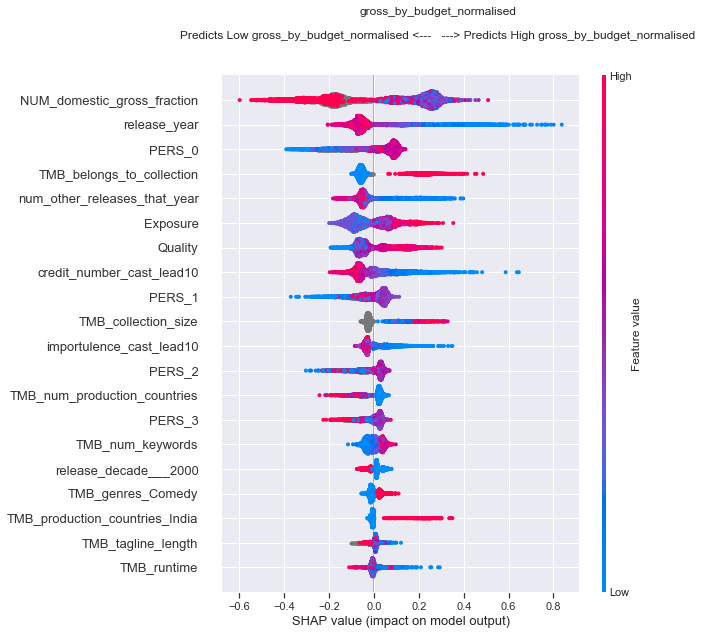

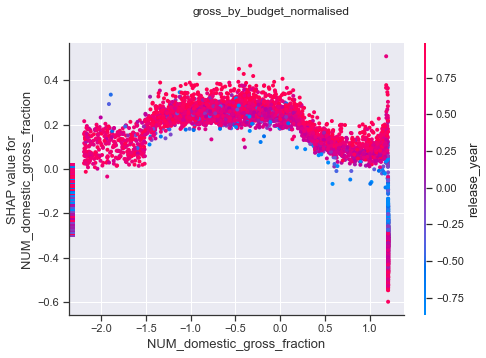

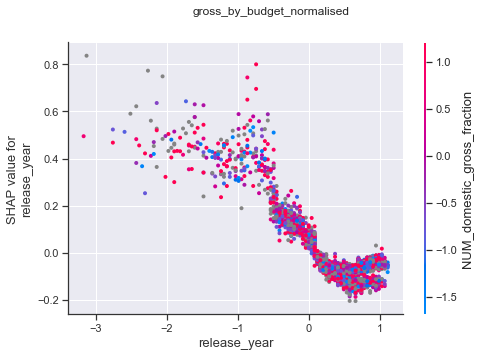

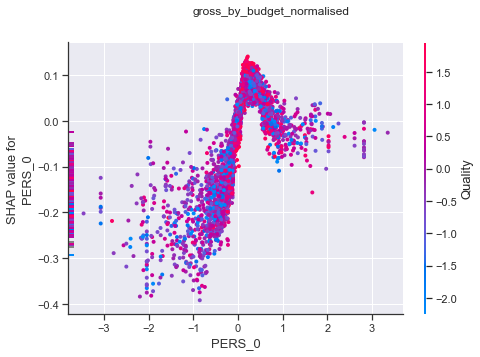

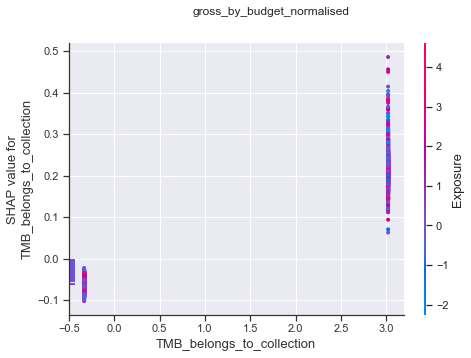

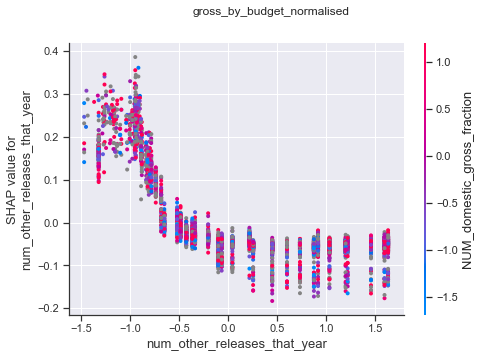

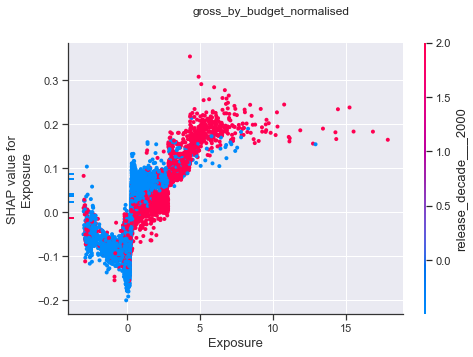

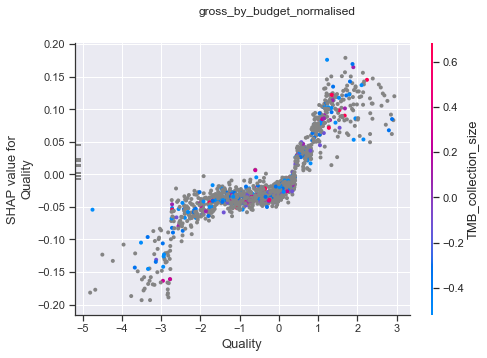

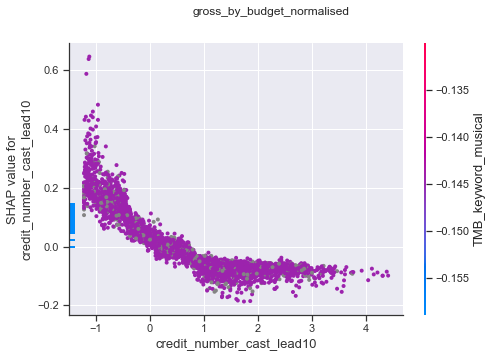

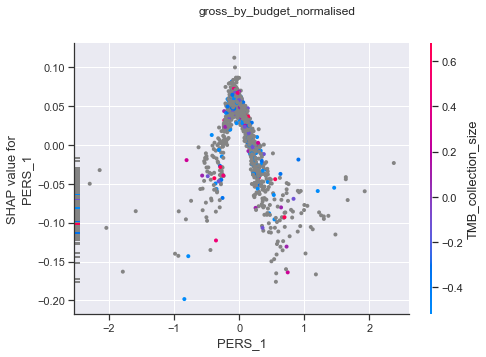

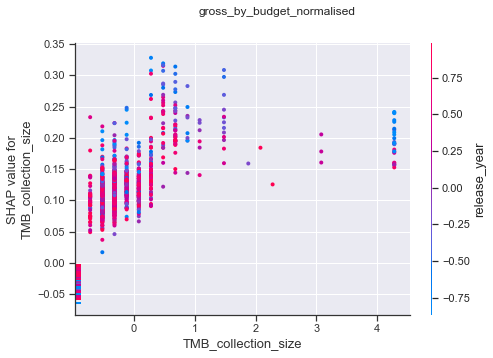

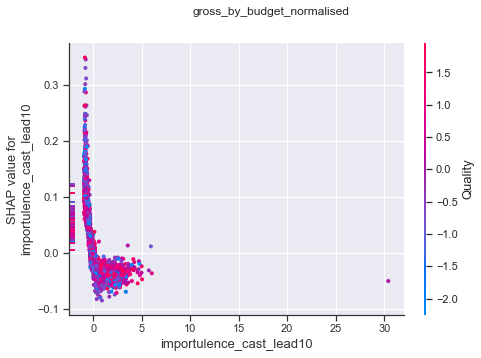

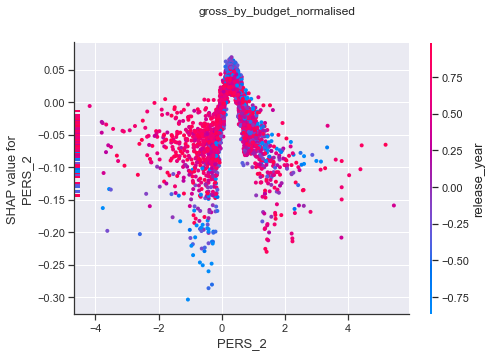

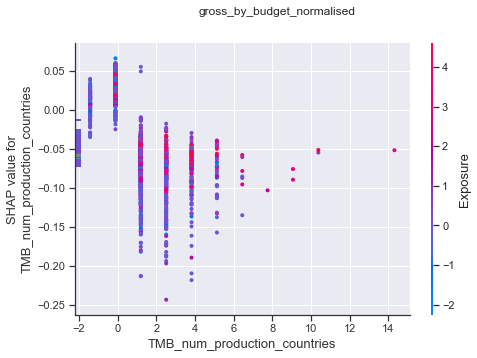

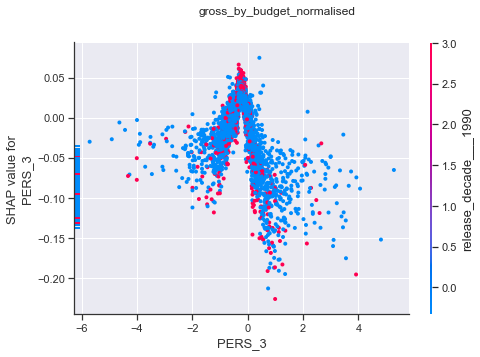

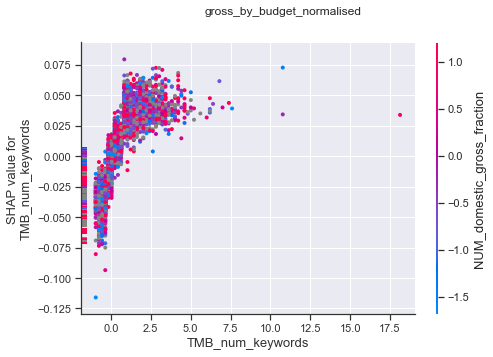

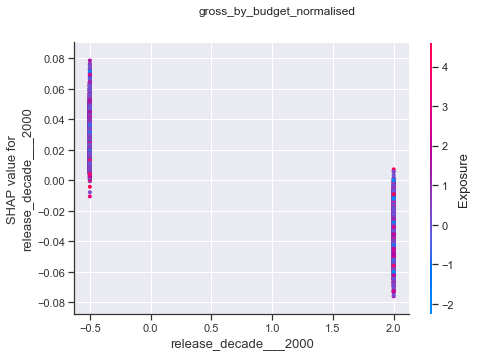

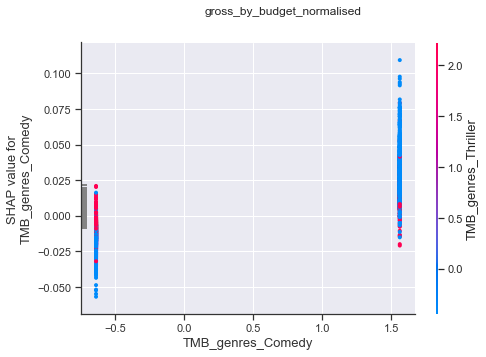

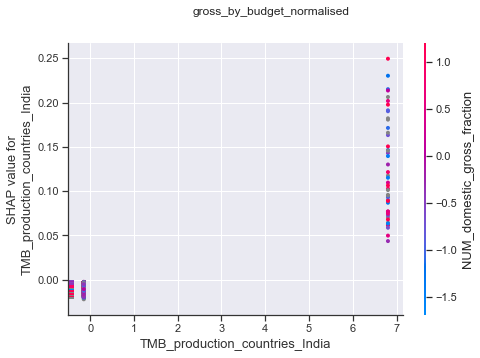

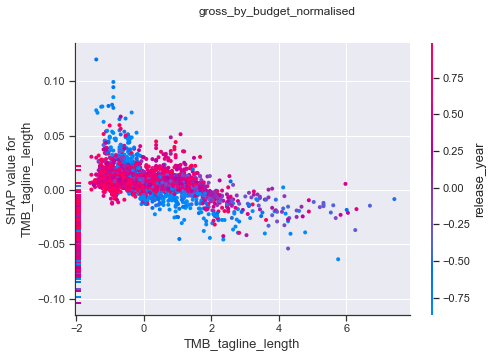

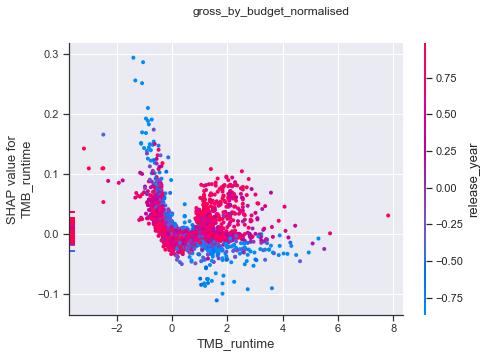

Wall time: 8min 14s


In [337]:
%%time
global BES_output_folder
drop_cols = list(release_decade_dummies.columns)
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend()

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
drop_cols = ["gross_normalised","budget_normalised"]
var_name = "gross_by_budget_normalised"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:58:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.08255
Will train until validation_0-rmse hasn't improved in 10.4 rounds.
[1]	validation_0-rmse:1.05559
[2]	validation_0-rmse:1.03311
[3]	validation_0-rmse:1.00883
[4]	validation_0-rmse:0.986915
[5]	validation_0-rmse:0.968058
[6]	validation_0-rmse:0.949004
[7]	validation_0-rmse:0.931203
[8]	validation_0-rmse:0.915202
[9]	validation_0-rmse:0.900426
[10]	validation_0-rmse:0.887395
[11]	validation_0-rmse:0.875154
[12]	validation_0-rmse:0.863448
[13]	validation_0-rmse:0.8531
[14]	validation_0-rmse:0.843237
[15]	validation_0-rmse:0.834515
[16]	validation_0-rmse:0.826057
[17]	validation_0-rmse:0.818371
[18]	validation_0-rmse:0.810973
[19]	validation_0-rmse:0.805995
[20]	validation_0-rmse:0.799284
[21]	validation_0-rmse:0.794406
[22]	validation_0-rmse:0.789532
[23]	validation_0-rmse:0.784846
[24]	validation_0

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:02:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


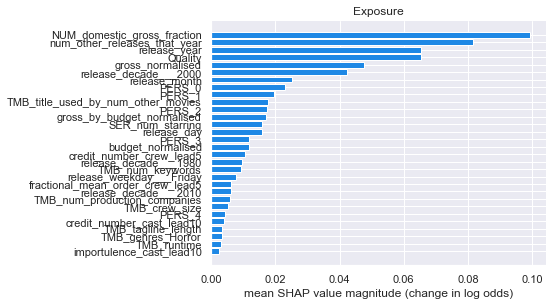

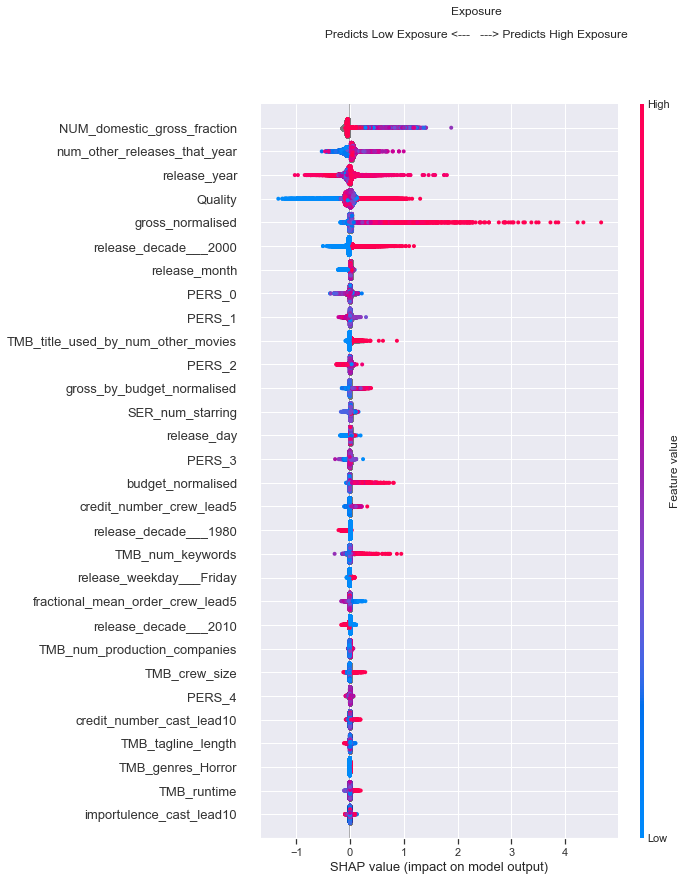

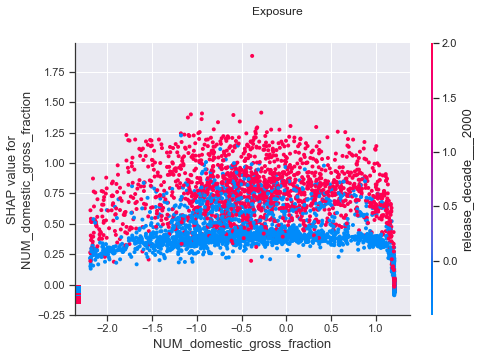

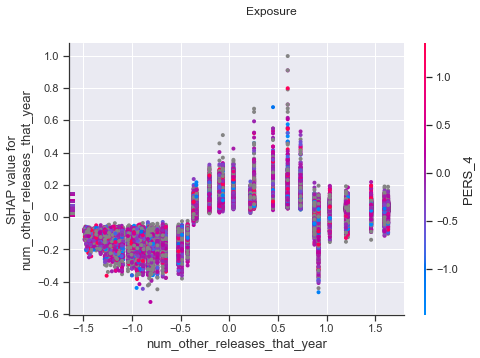

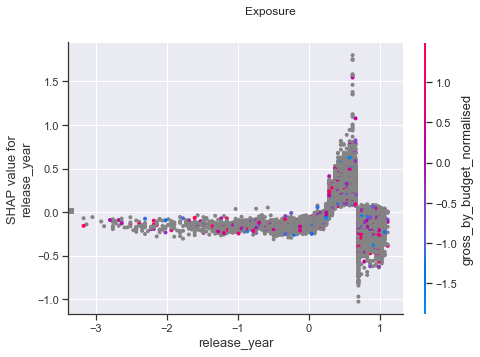

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


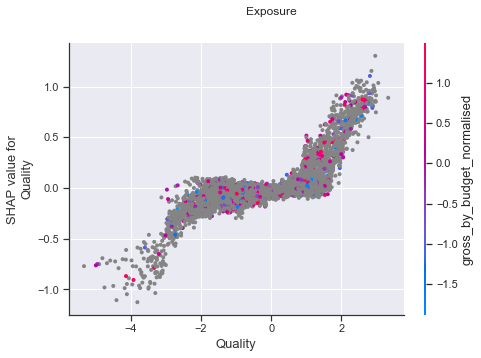

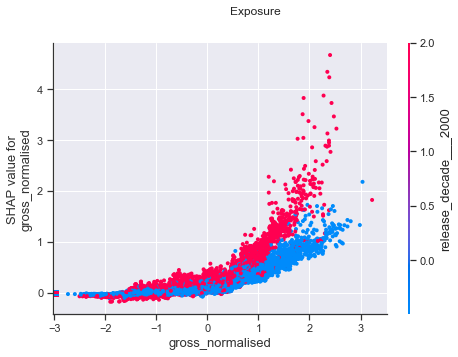

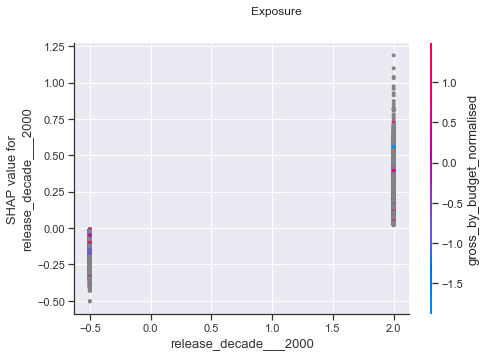

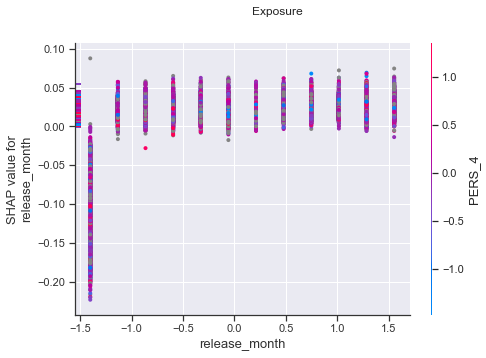

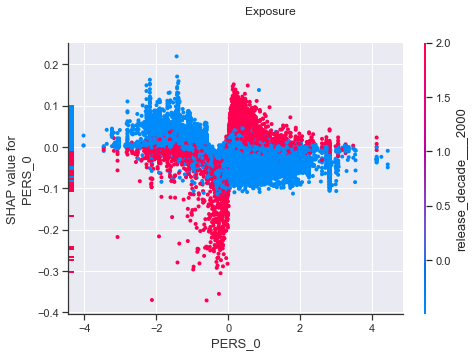

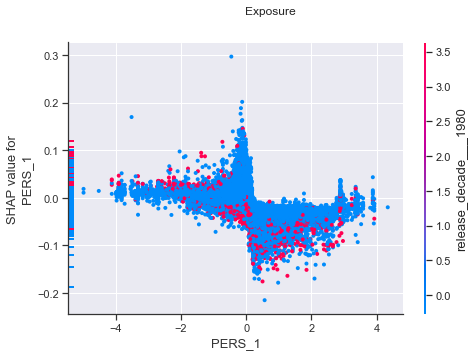

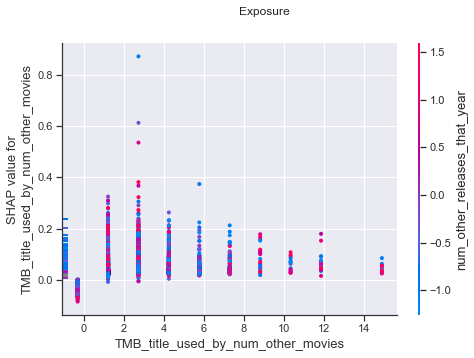

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


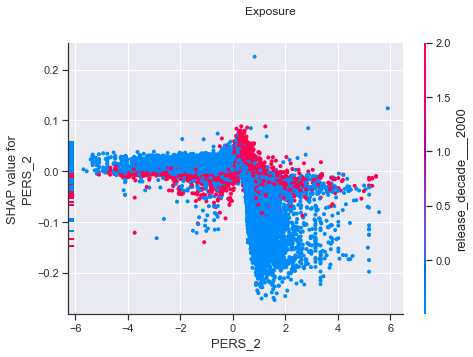

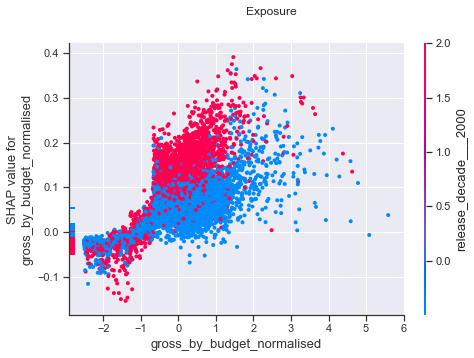

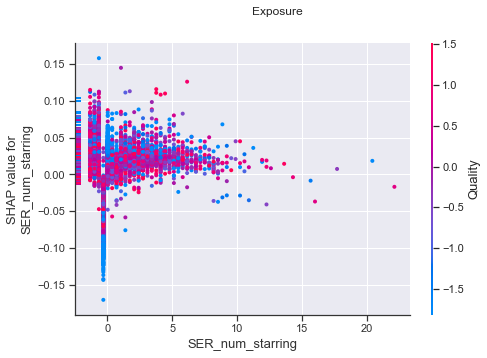

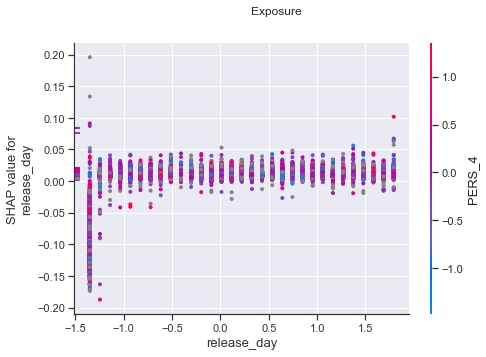

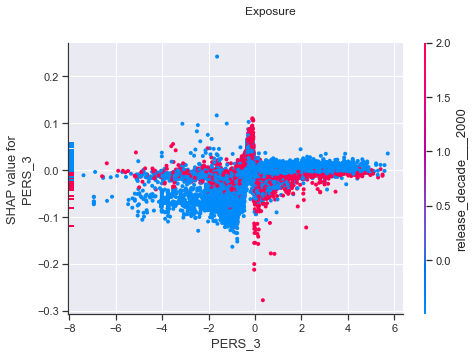

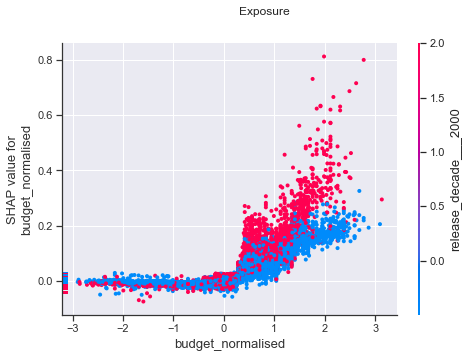

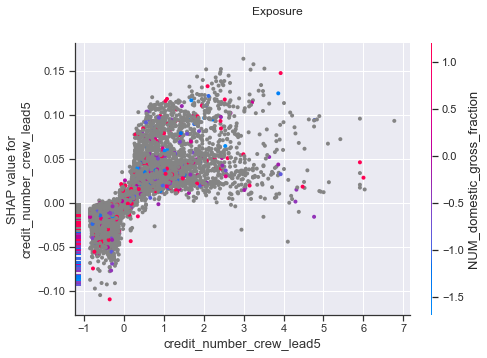

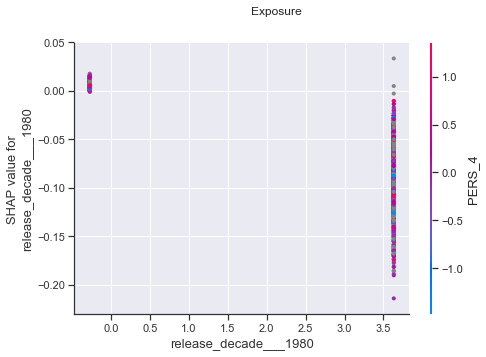

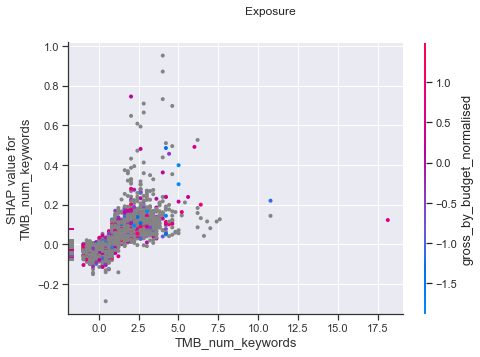

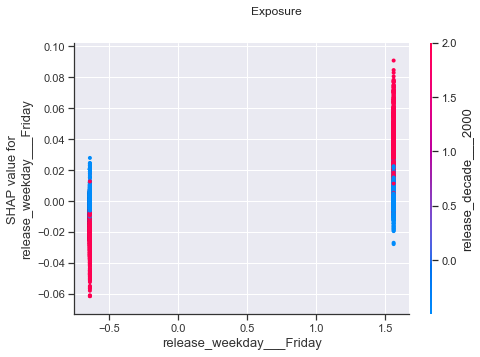

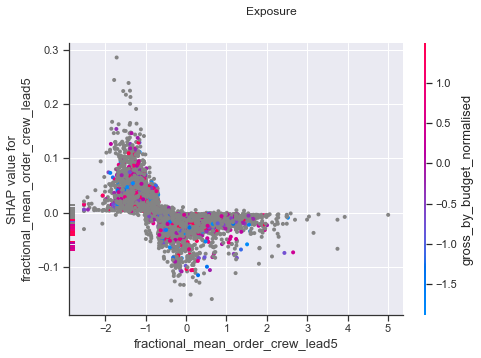

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


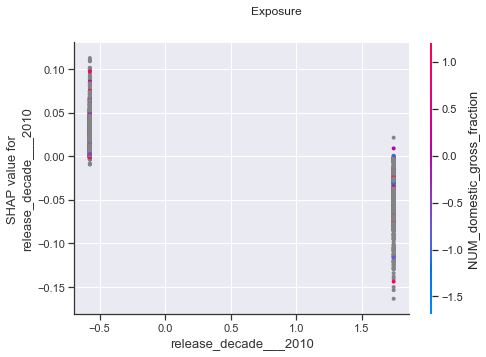

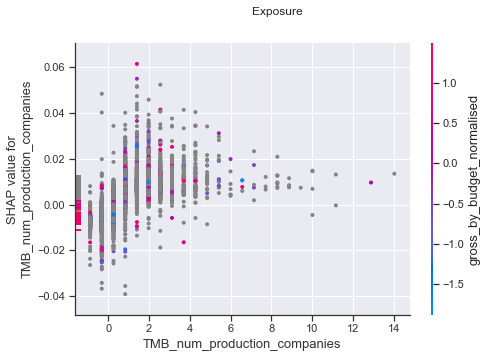

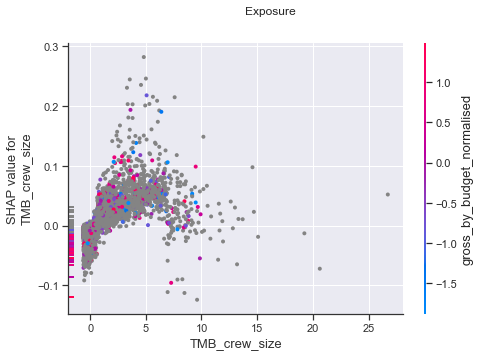

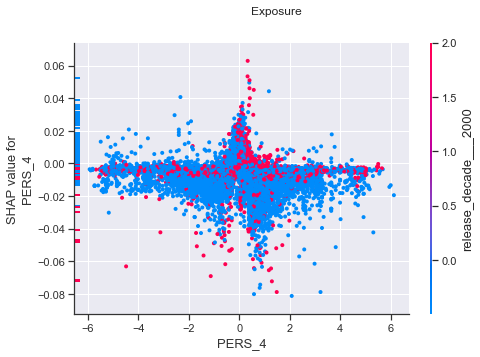

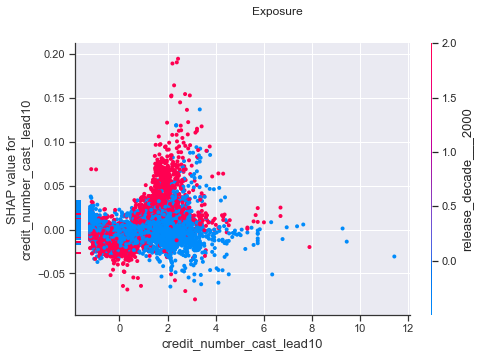

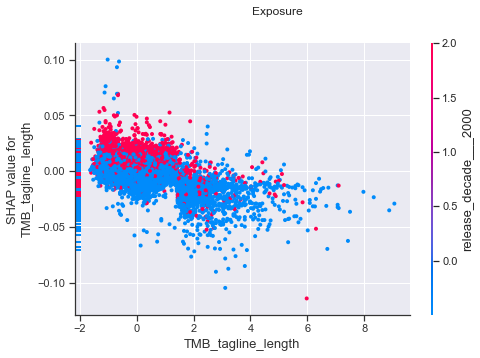

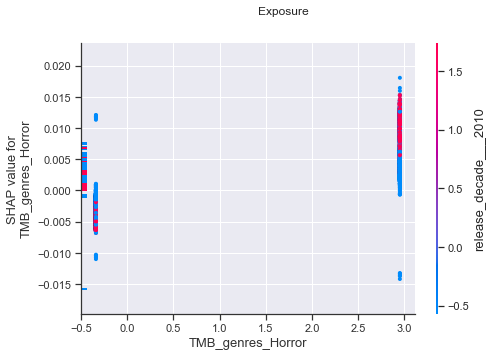

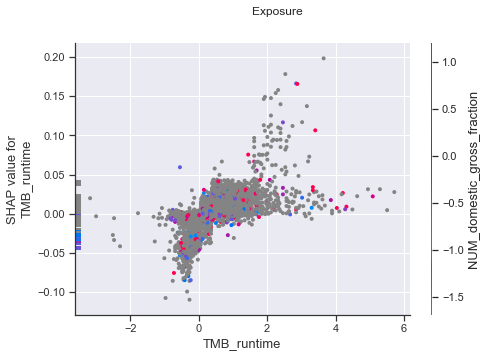

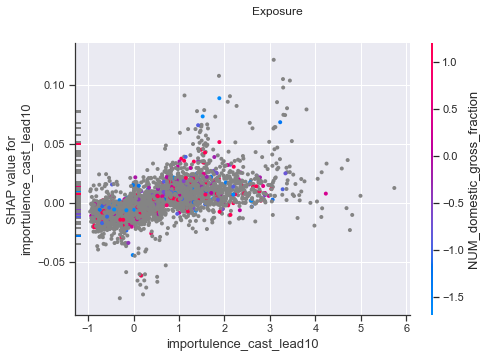

Wall time: 27min 53s


In [317]:
%%time

drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend(fused_cols)

# drop_cols.extend(["tops","flops"])
var_name = "Exposure"


BES_output_folder= ".."+os.sep+"Output"+os.sep

df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )
mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:26:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.10295
Will train until validation_0-rmse hasn't improved in 10.3 rounds.
[1]	validation_0-rmse:1.08513
[2]	validation_0-rmse:1.06775
[3]	validation_0-rmse:1.05155
[4]	validation_0-rmse:1.03702
[5]	validation_0-rmse:1.02442
[6]	validation_0-rmse:1.01218
[7]	validation_0-rmse:1.0009
[8]	validation_0-rmse:0.99078
[9]	validation_0-rmse:0.98129
[10]	validation_0-rmse:0.971712
[11]	validation_0-rmse:0.962942
[12]	validation_0-rmse:0.954737
[13]	validation_0-rmse:0.947451
[14]	validation_0-rmse:0.940721
[15]	validation_0-rmse:0.934458
[16]	validation_0-rmse:0.928456
[17]	validation_0-rmse:0.922645
[18]	validation_0-rmse:0.917586
[19]	validation_0-rmse:0.912514
[20]	validation_0-rmse:0.907904
[21]	validation_0-rmse:0.903617
[22]	validation_0-rmse:0.899809
[23]	validation_0-rmse:0.895712
[24]	validation_0-rmse

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:30:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


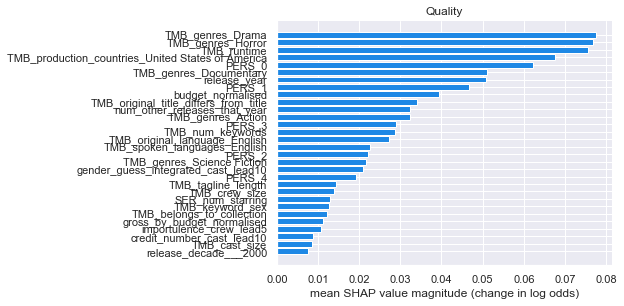

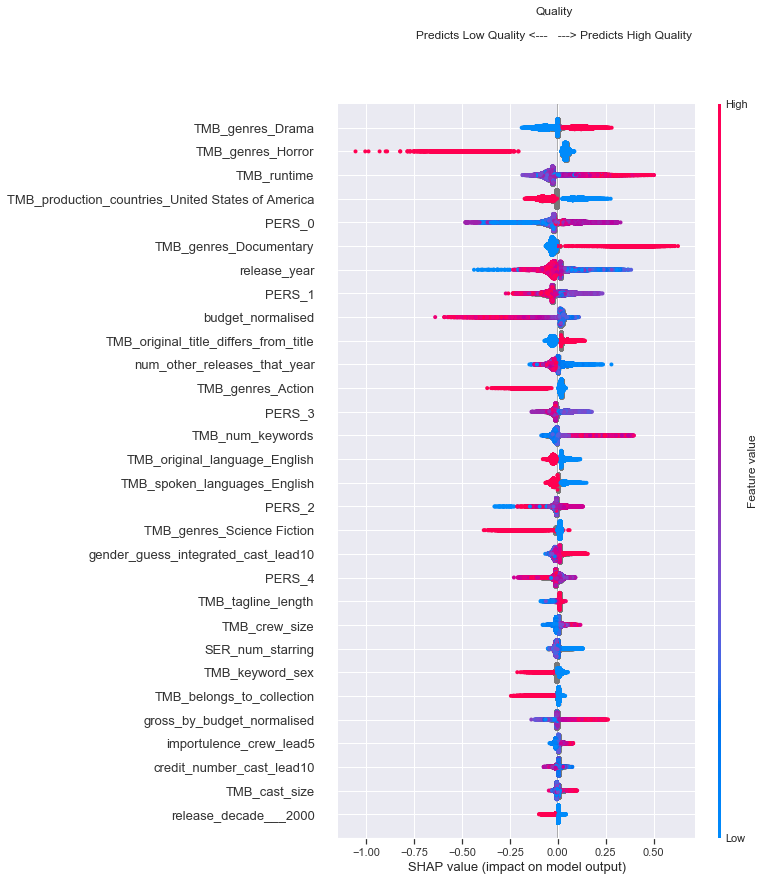

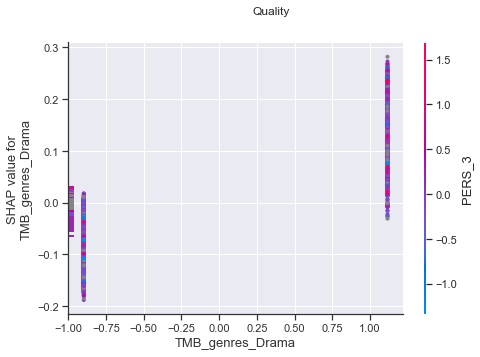

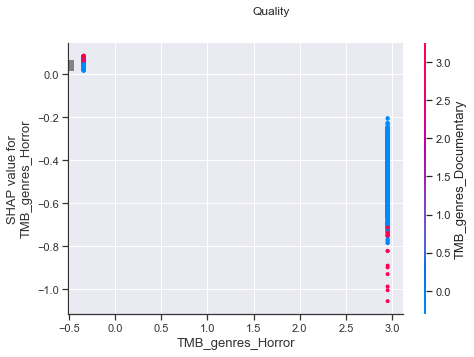

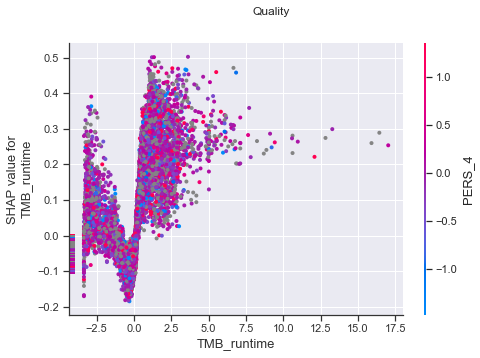

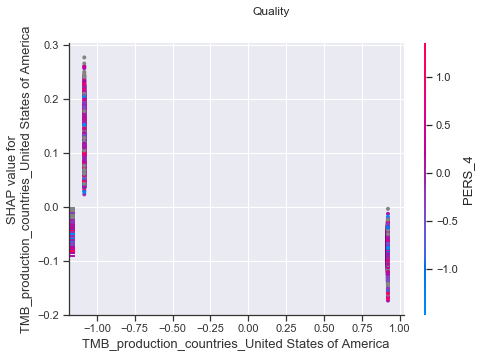

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


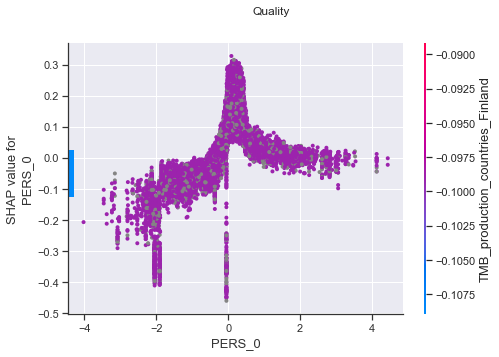

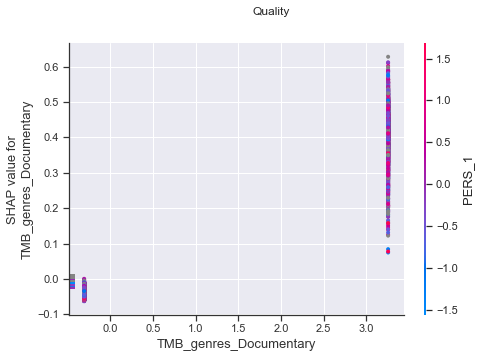

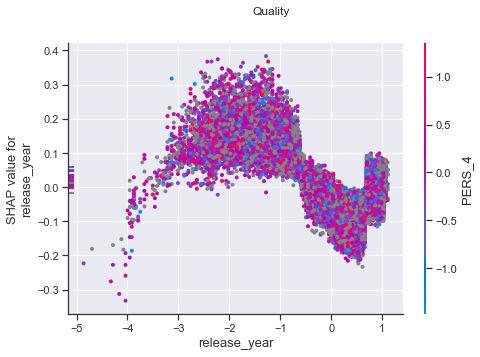

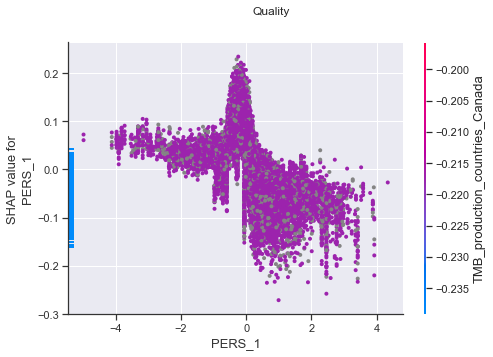

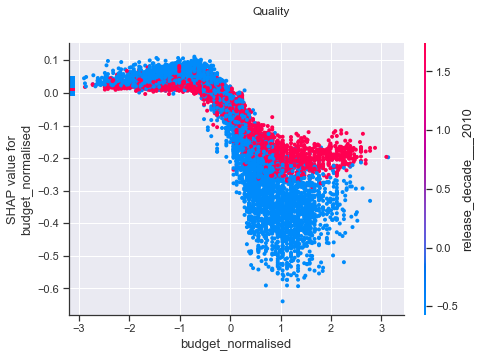

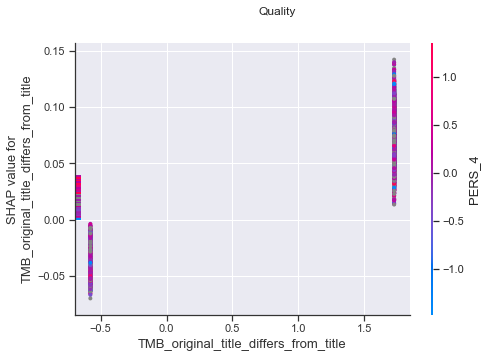

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


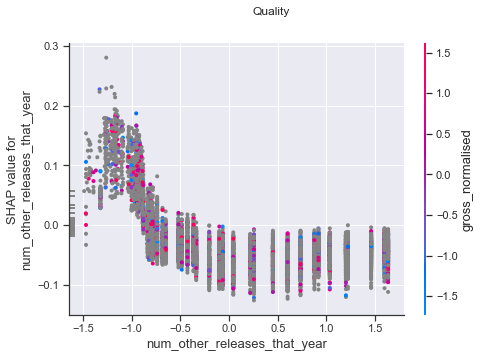

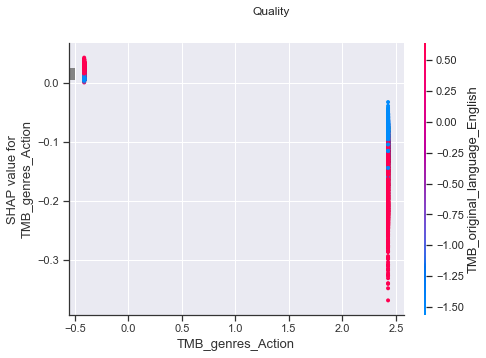

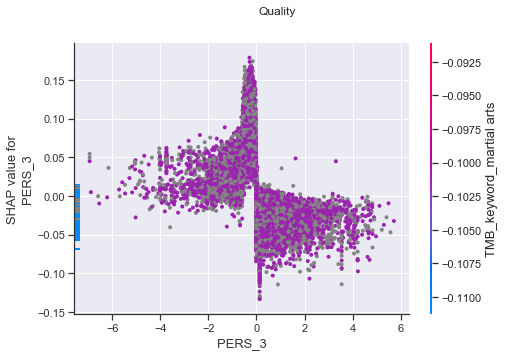

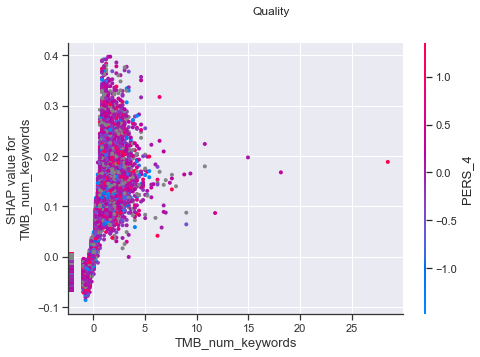

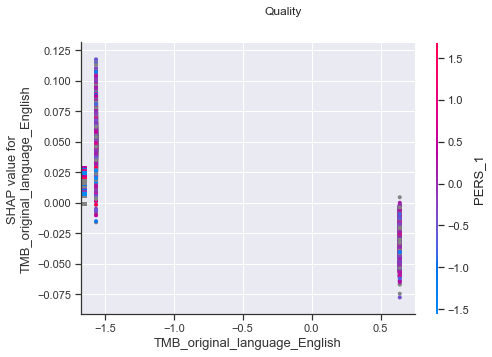

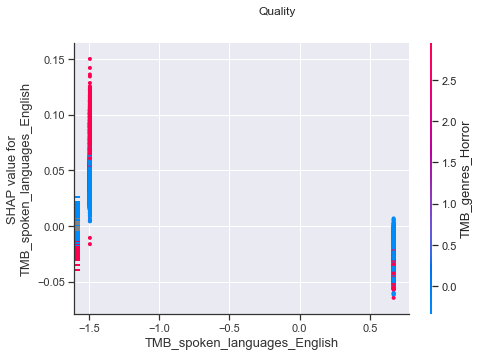

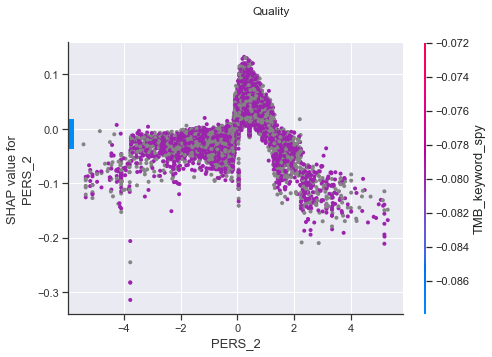

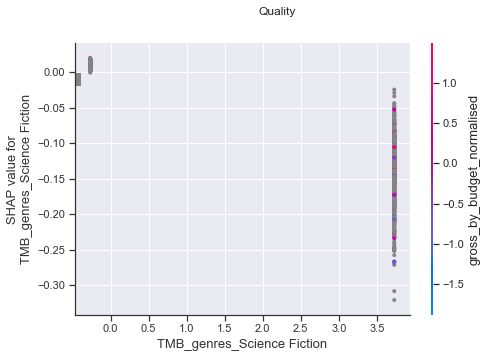

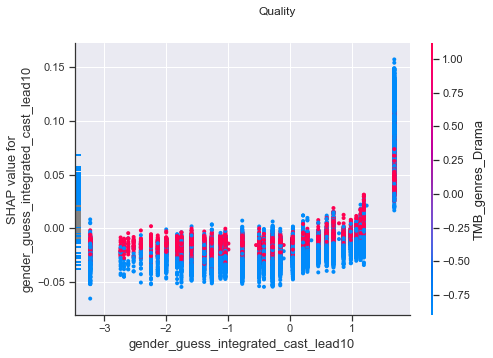

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


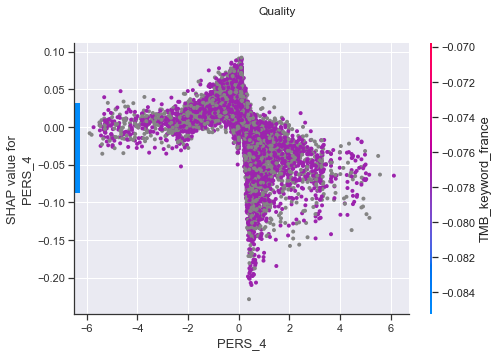

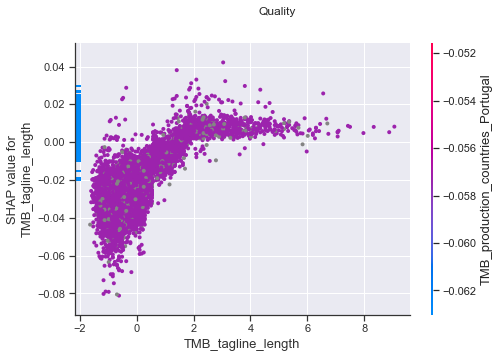

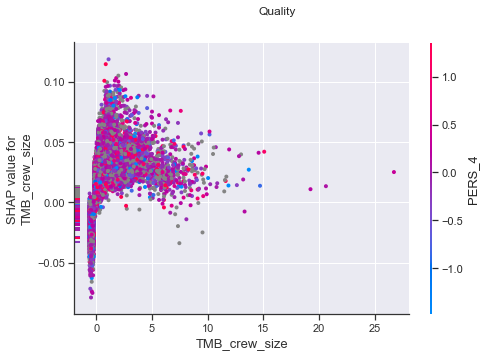

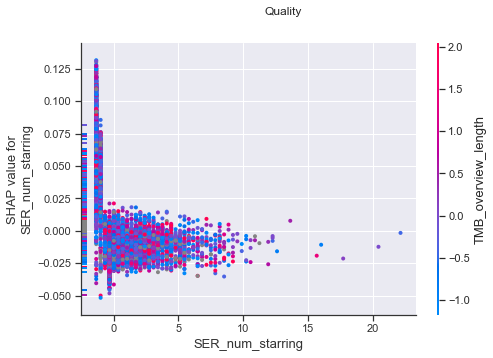

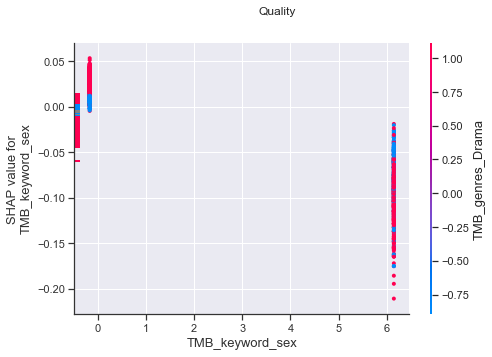

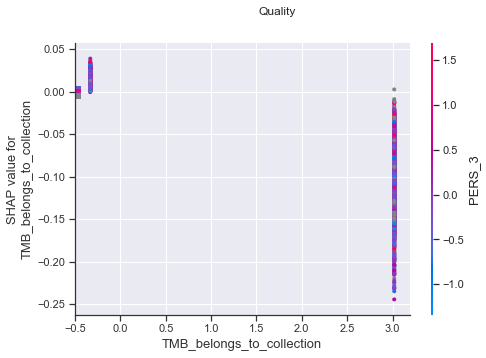

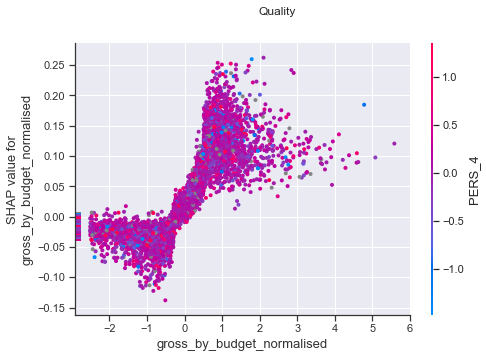

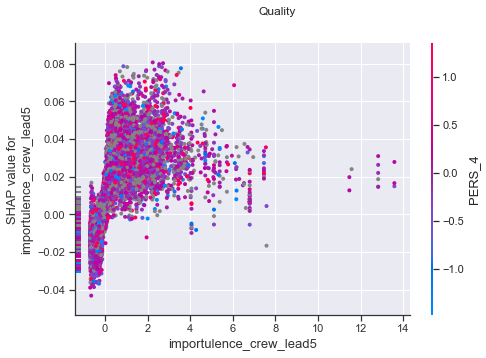

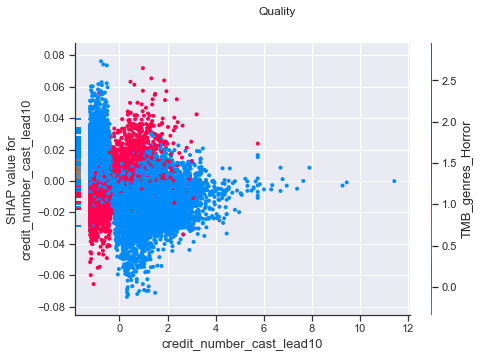

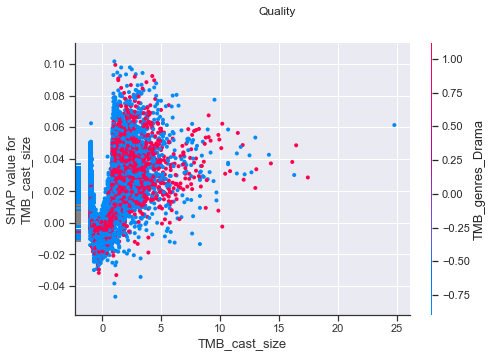

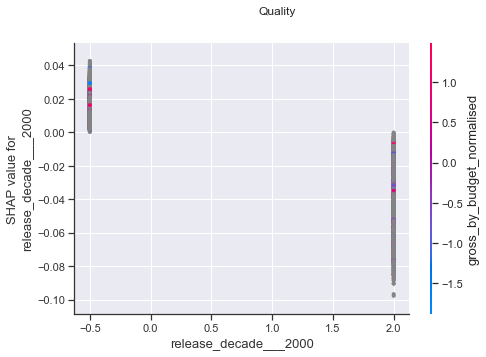

Wall time: 28min 4s


In [318]:
%%time

drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

drop_cols.extend(["Exposure"])

# drop_cols.extend(["tops","flops"])
var_name = "Quality"


BES_output_folder= ".."+os.sep+"Output"+os.sep

df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )
mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,30),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True)


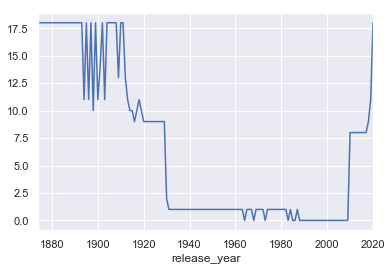

In [7]:
(INT_df.groupby("release_year")[ratings_cols].count()<10).sum(axis=1).plot()
# chop before

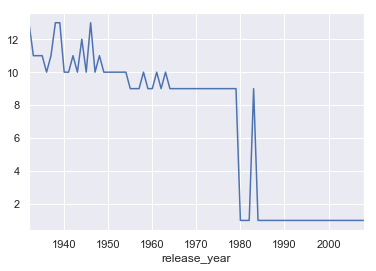

In [9]:
var0 = "release_year"
mask = (INT_df[var0]>1931) & (INT_df[var0]<2009)
(INT_df[mask].groupby("release_year")[ratings_cols].count()<100).sum(axis=1).plot()

In [18]:
from wpca import PCA, WPCA, EMPCA

In [31]:
np.linalg.matrix_rank( BES_std.fillna(BES_std.mean()).values, 1 )

18

In [60]:
ratings_cols = ['HETREC_rtAudienceScore', 'HETREC_rtAudienceNumRatings',
       'HETREC_rtTopCriticsNumReviews', 'HETREC_rtAllCriticsNumReviews',
       'ML_ratings_mean', 'SER_ratings_mean', 'TMB_vote_average_normalised',
       'HETREC_rtAllCriticsScore', 'PERS_ratings_mean', 'HETREC_ratings_mean',
       'TMB_vote_count', 'TMB_popularity_normalised',
       'SER_rating',"HETREC_rtTopCriticsScore",
        'HETREC_ratings_std','SER_ratings_std','PERS_ratings_std','ML_ratings_std']
# ratings_cols.remove("HETREC_rtTopCriticsNumReviews")
# ratings_cols.remove("SER_ratings_mean")
# ratings_cols.remove("SER_ratings_std")
# ratings_cols.remove("HETREC_ratings_mean")
# ratings_cols.remove("PERS_ratings_mean")
# ratings_cols.remove("HETREC_ratings_std")
# ratings_cols.remove("PERS_ratings_std")

# ratings_cols = ['HETREC_rtAudienceScore', 'ML_ratings_mean']

In [41]:
data.notnull().sum().sort_values()

SER_rating                        1666
HETREC_ratings_std                9505
HETREC_rtAudienceScore            9966
HETREC_rtAudienceNumRatings       9966
HETREC_rtAllCriticsNumReviews     9966
HETREC_rtTopCriticsScore          9966
HETREC_rtAllCriticsScore          9966
HETREC_ratings_mean              10106
PERS_ratings_std                 24057
PERS_ratings_mean                35135
SER_ratings_std                  39428
TMB_vote_average_normalised      42460
ML_ratings_std                   43659
TMB_vote_count                   45354
TMB_popularity_normalised        45354
SER_ratings_mean                 49072
ML_ratings_mean                  53810
dtype: int64

In [33]:
%%time
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())

naive_cross_corrs = data.corr()    
pd.set_option('max_colwidth', 80)
corrank(naive_cross_corrs) # prints a descending list of correlation pair (Max on top)

                                                              pairs      corr
33   (HETREC_rtTopCriticsNumReviews, HETREC_rtAllCriticsNumReviews)  0.959386
62                              (ML_ratings_mean, SER_ratings_mean)  0.937841
151                               (SER_ratings_std, ML_ratings_std)  0.893246
66                           (ML_ratings_mean, HETREC_ratings_mean)  0.812526
65                             (ML_ratings_mean, PERS_ratings_mean)  0.739576
108                        (PERS_ratings_mean, HETREC_ratings_mean)  0.729220
77                            (SER_ratings_mean, PERS_ratings_mean)  0.715193
12               (HETREC_rtAudienceScore, HETREC_rtTopCriticsScore)  0.705887
78                          (SER_ratings_mean, HETREC_ratings_mean)  0.680305
89               (TMB_vote_average_normalised, HETREC_ratings_mean)  0.634194
64                      (ML_ratings_mean, HETREC_rtAllCriticsScore)  0.621151
103            (HETREC_rtAllCriticsScore, HETREC_rtTopCriticsSco

In [63]:
INT_df[ratings_cols].notnull().any(axis=1).sum()

55670

In [64]:
INT_df.shape

(59324, 933)

In [67]:
data = INT_df[ratings_cols].copy()
drop_movies = data[data.isnull().all(axis=1)].index
data.drop(drop_movies,inplace=True)


weights = data.notnull().astype('float')

clean_feature_set_std = StandardScaler().fit_transform(data.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = data.columns,
                             index   = data.index      )

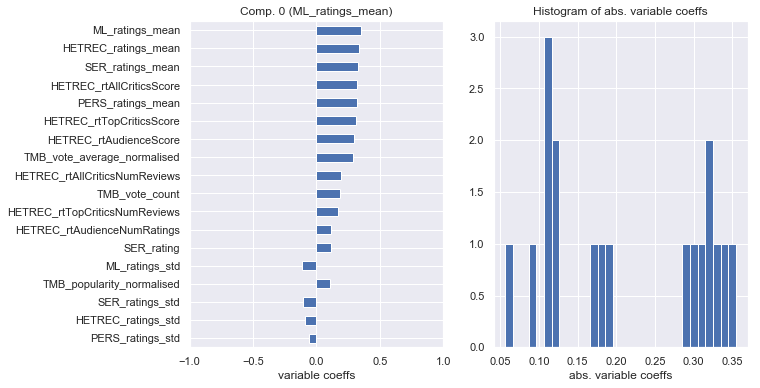

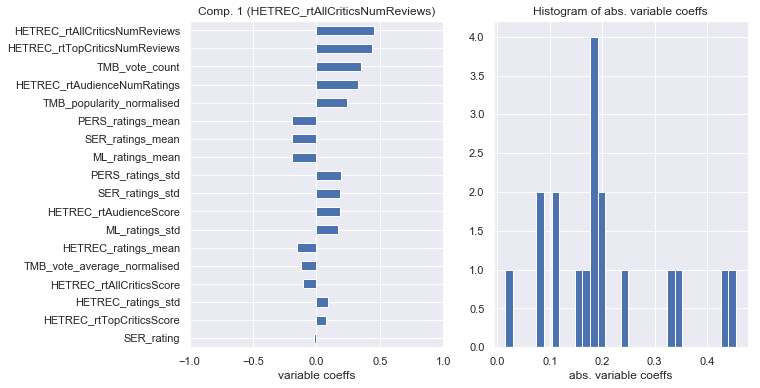

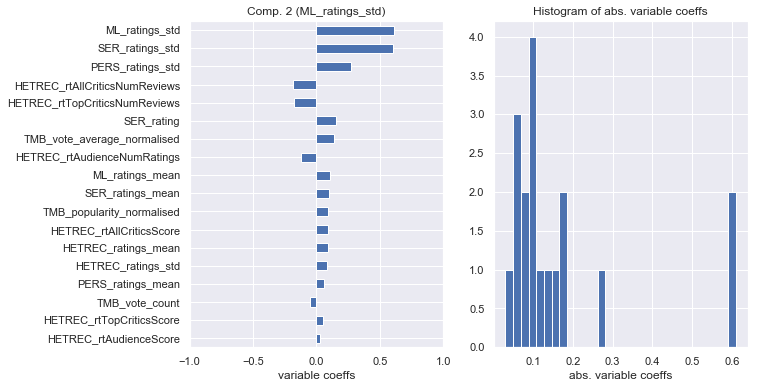

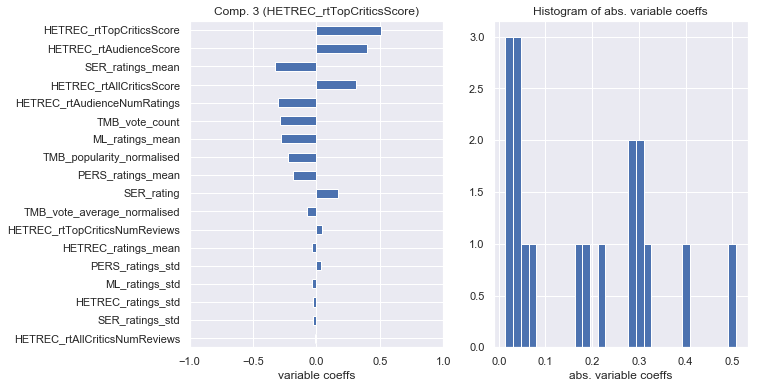

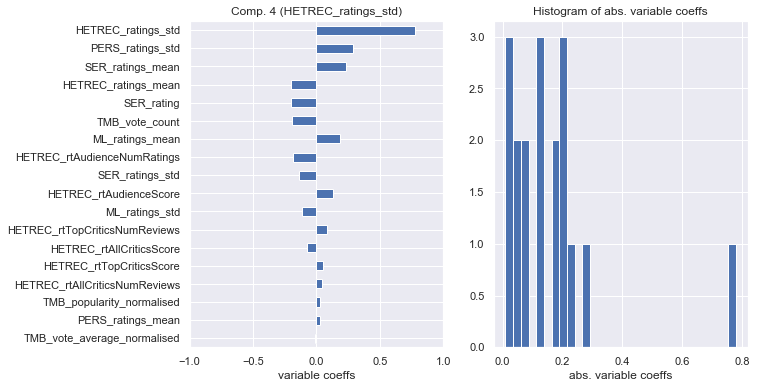

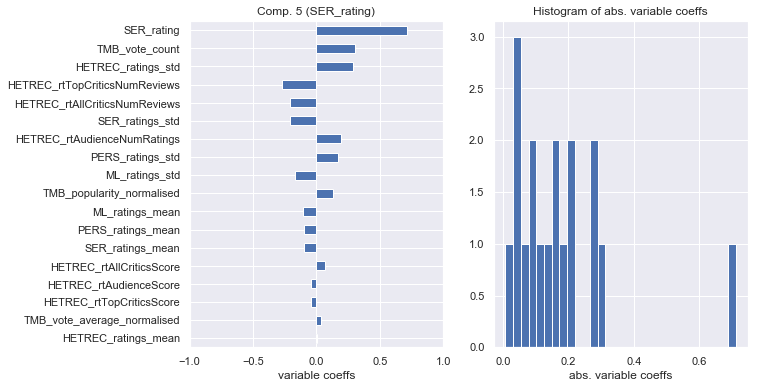

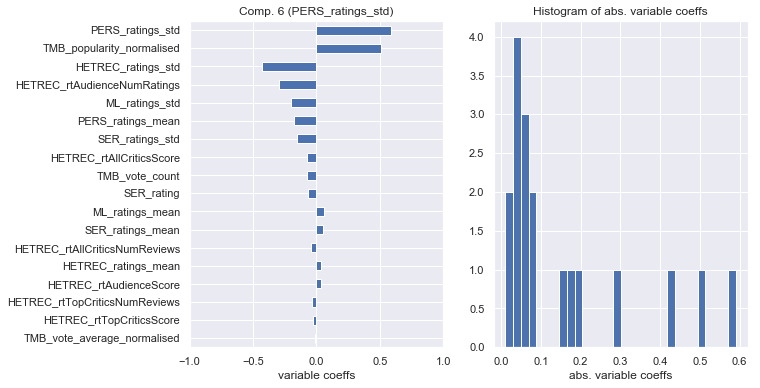

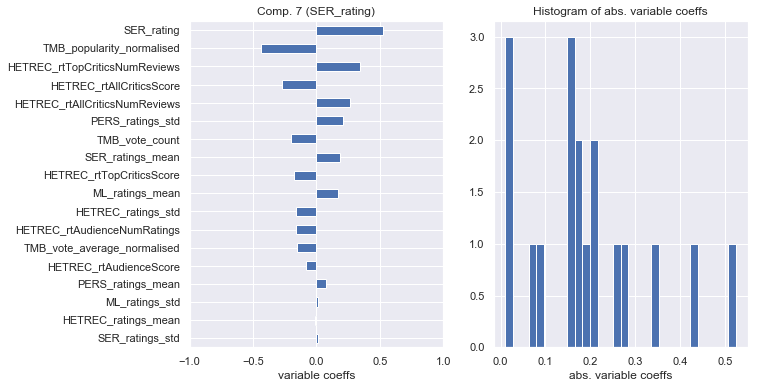

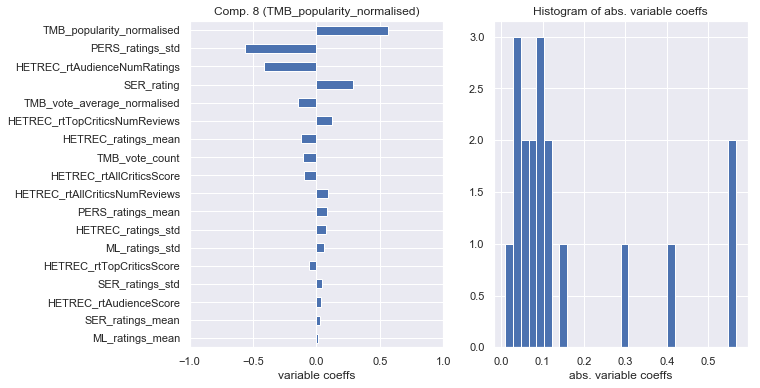

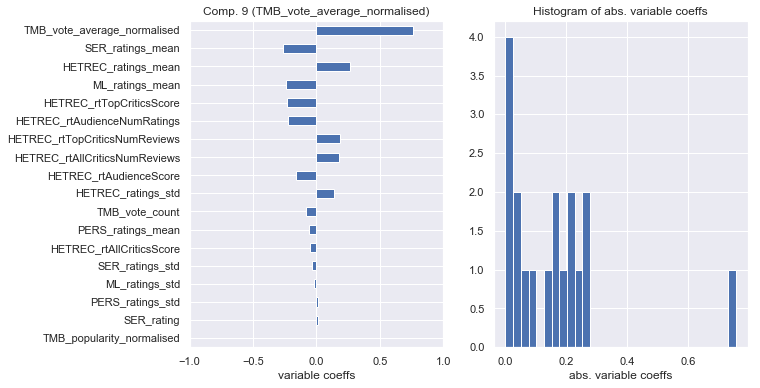

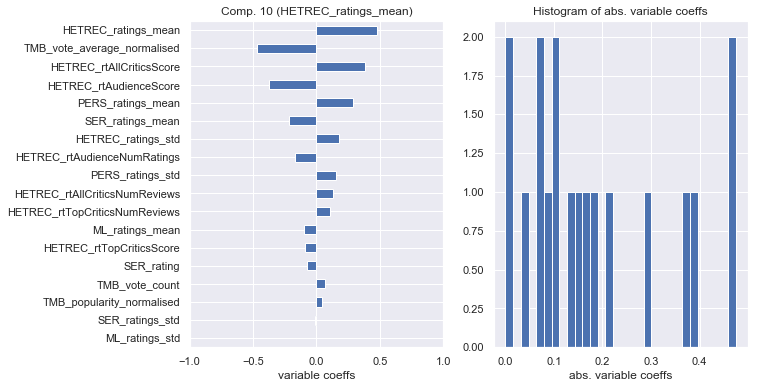

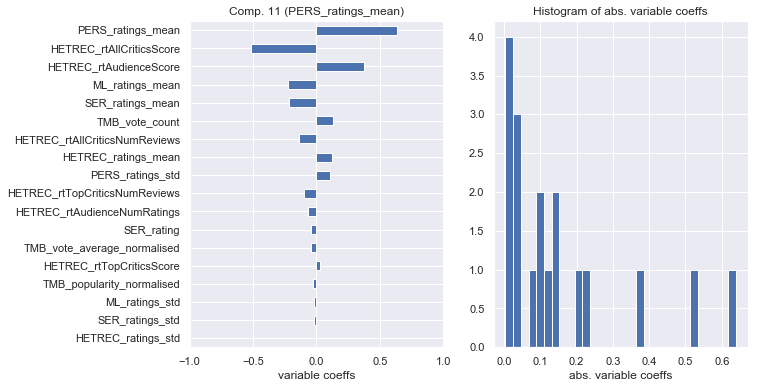

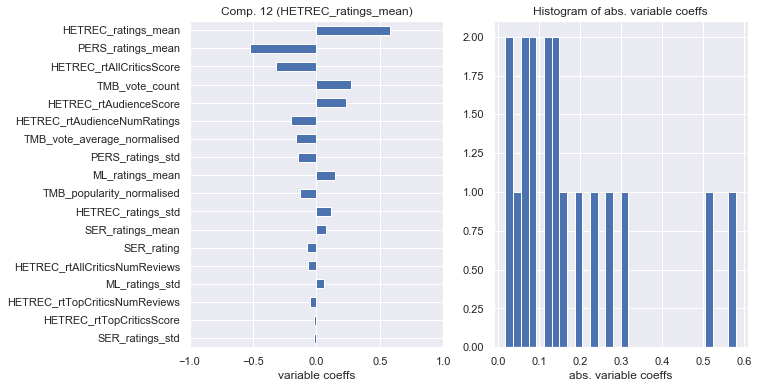

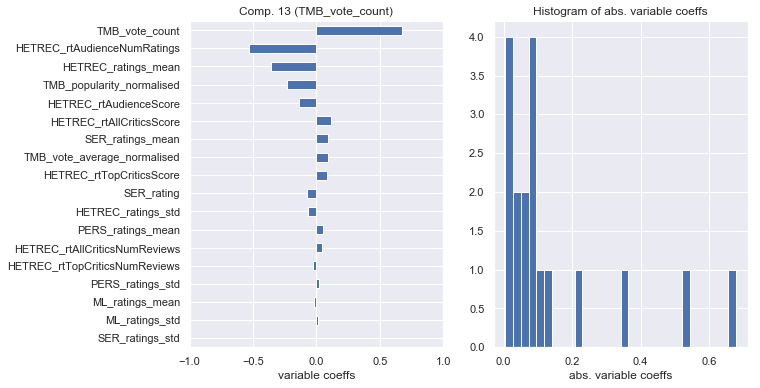

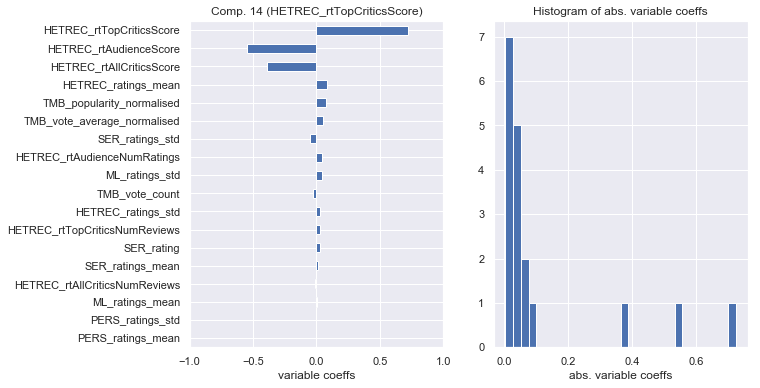

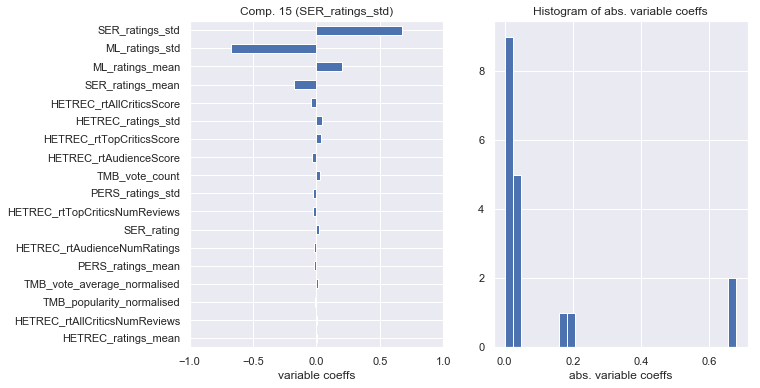

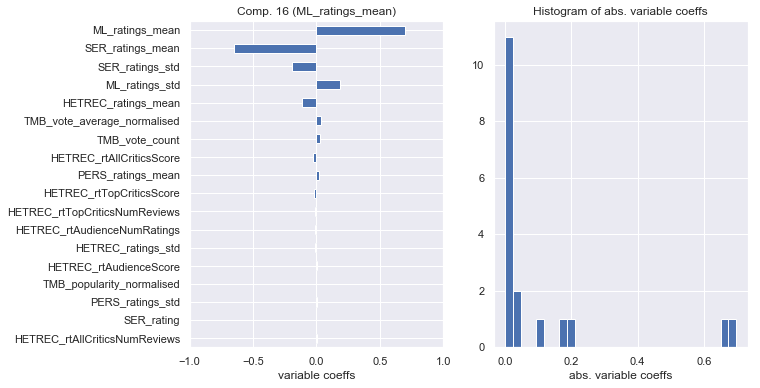

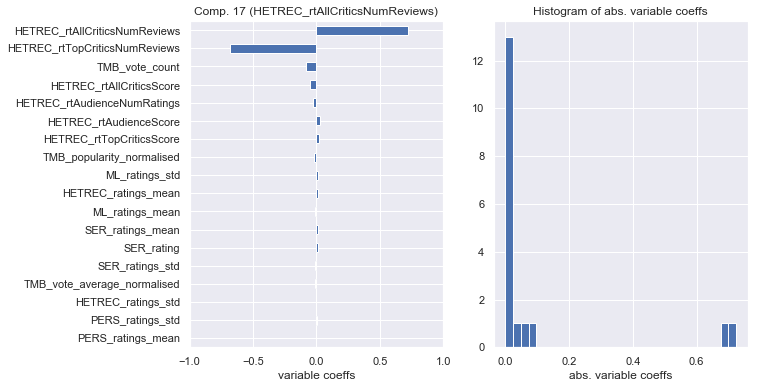

In [82]:
# decomp = EMPCA(n_components=2) # super slow!
decomp = WPCA(n_components=18) #332ms # (n_components=30)
# decomp = PCA() # svd_solver='full' # 2s


decomp_method = str(decomp).split("(")[0]
# decomp_method = "EWPCA" # 21 minutes
if len(weights) ==0 or decomp_method == "PCA":
    kwds = {}
else:
    kwds = {'weights': weights}

X_r = decomp.fit_transform(BES_std, **kwds)
n_components = decomp.components_.shape[0]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = data.index)


subdir = create_subdir(".."+os.sep+"Output"+os.sep,"ratings_fusion_wpca")

(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          data.columns, BES_decomp, manifest=None,
                                                          save_folder = subdir, 
                                                          show_first_x_comps= 20, show_histogram = True)

In [77]:
# decomp = EMPCA(n_components=2) # super slow!
# # decomp = WPCA(n_components=2) #332ms # (n_components=30)
# # decomp = PCA() # svd_solver='full' # 2s


# decomp_method = str(decomp).split("(")[0]
# # decomp_method = "EWPCA" # 21 minutes
# if len(weights) ==0 or decomp_method == "PCA":
#     kwds = {}
# else:
#     kwds = {'weights': weights}

# X_r = decomp.fit_transform(BES_std, **kwds)
# n_components = decomp.components_.shape[0]
# BES_decomp = pd.DataFrame(   X_r,
#                              columns = range(0,n_components),
#                              index   = data.index)


# subdir = create_subdir(".."+os.sep+"Output"+os.sep,"ratings_fusion_wpca")

# (BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
#                                                           data.columns, BES_decomp, manifest=None,
#                                                           save_folder = subdir, 
#                                                           show_first_x_comps= 20, show_histogram = True)

Warning, filename truncated because it was over 50. Filenames may no longer be unique


C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:54:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.09989
Will train until validation_0-rmse hasn't improved in 10.200000000000001 rounds.
[1]	validation_0-rmse:1.08529
[2]	validation_0-rmse:1.07249
[3]	validation_0-rmse:1.06025
[4]	validation_0-rmse:1.04887
[5]	validation_0-rmse:1.03878
[6]	validation_0-rmse:1.02977
[7]	validation_0-rmse:1.02133
[8]	validation_0-rmse:1.01327
[9]	validation_0-rmse:1.00598
[10]	validation_0-rmse:0.999332
[11]	validation_0-rmse:0.993334
[12]	validation_0-rmse:0.988102
[13]	validation_0-rmse:0.983237
[14]	validation_0-rmse:0.978652
[15]	validation_0-rmse:0.974709
[16]	validation_0-rmse:0.971081
[17]	validation_0-rmse:0.967593
[18]	validation_0-rmse:0.964814
[19]	validation_0-rmse:0.962044
[20]	validation_0-rmse:0.959516
[21]	validation_0-rmse:0.957146
[22]	validation_0-rmse:0.955302
[23]	validation_0-rmse:0.953003
[24]	va

C:\ProgramData\Anaconda3\envs\Cook_Tortoise_Imdb_project\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:55:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


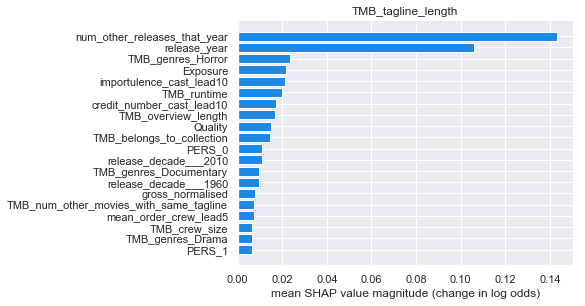

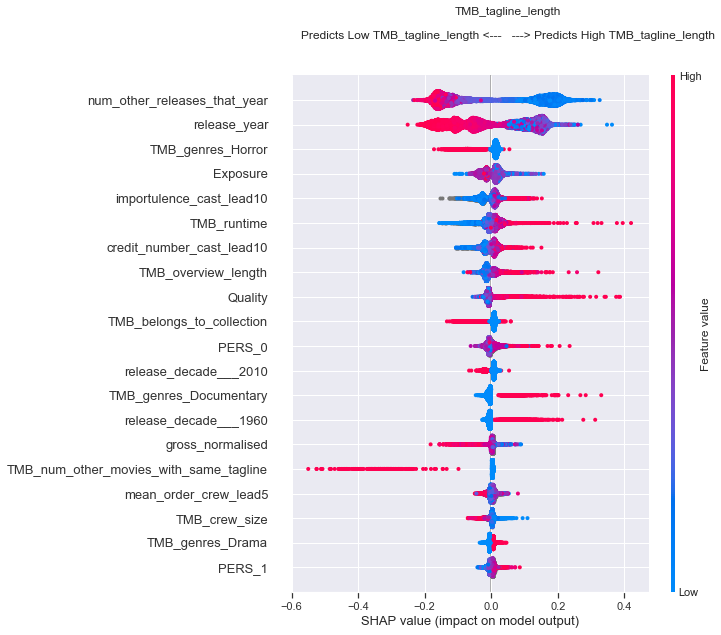

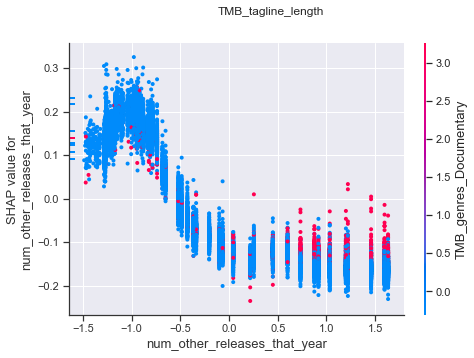

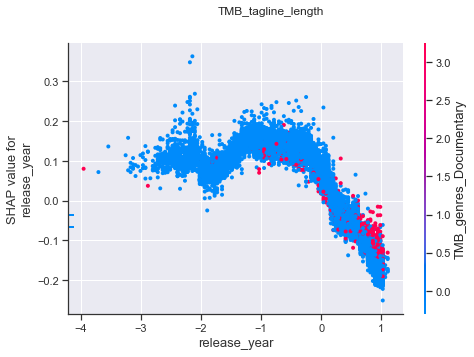

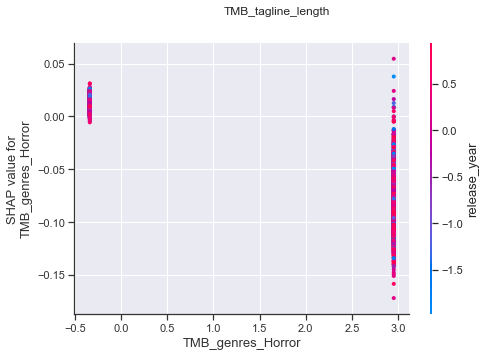

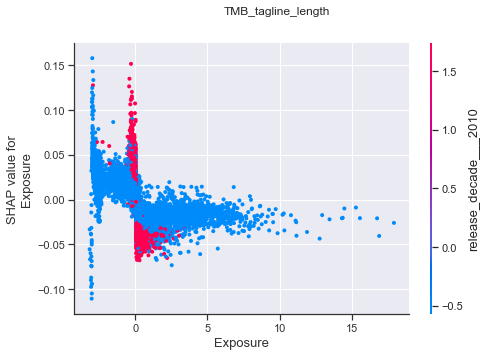

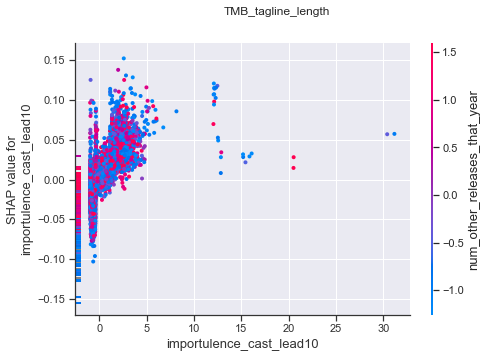

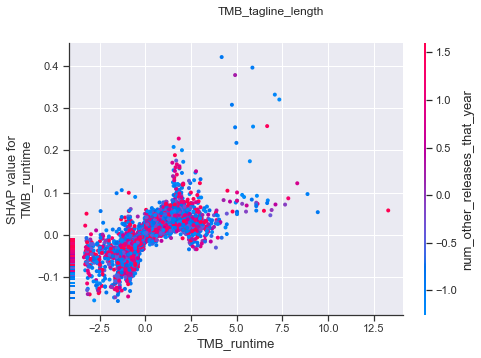

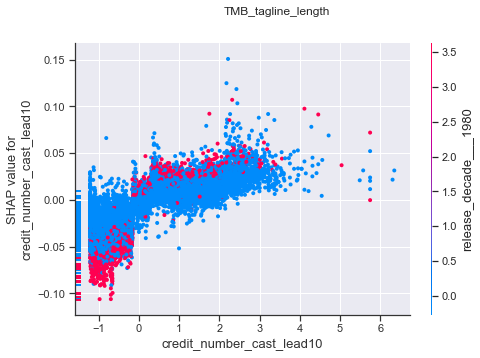

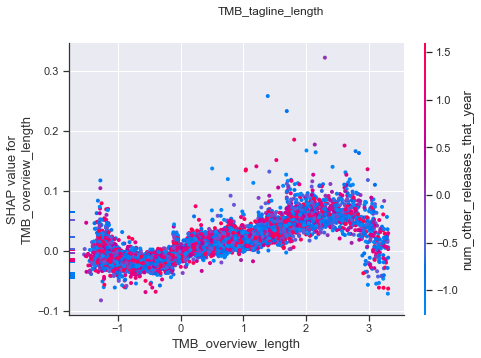

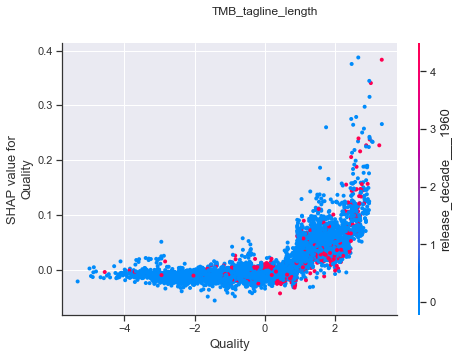

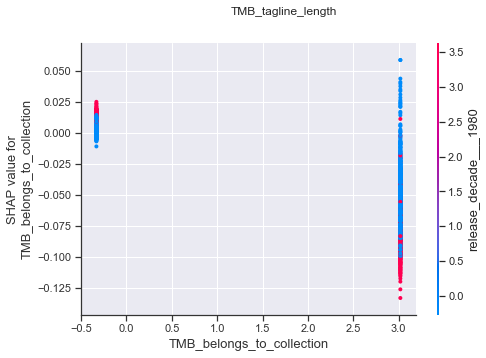

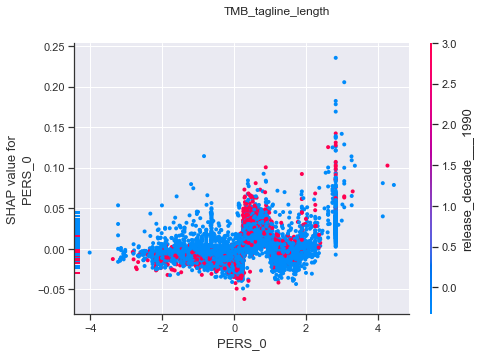

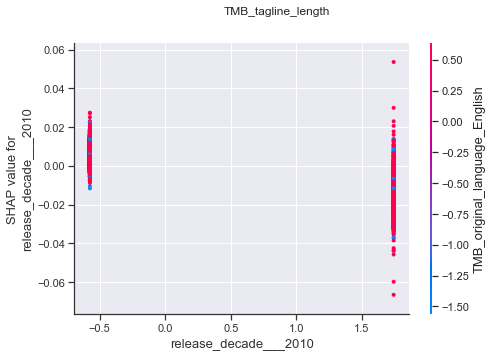

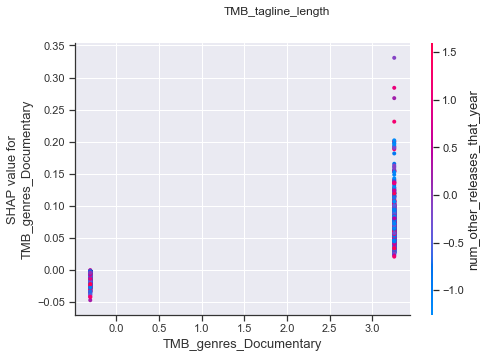

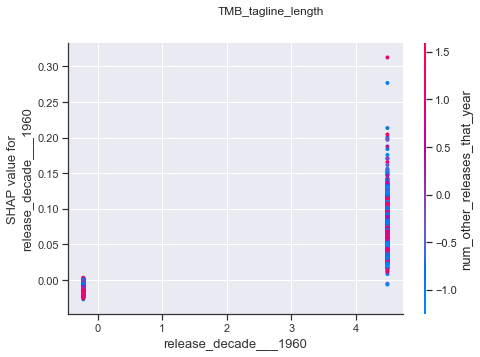

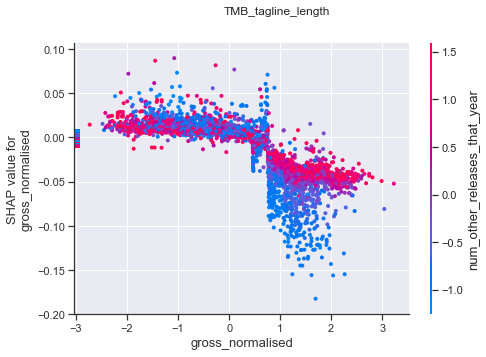

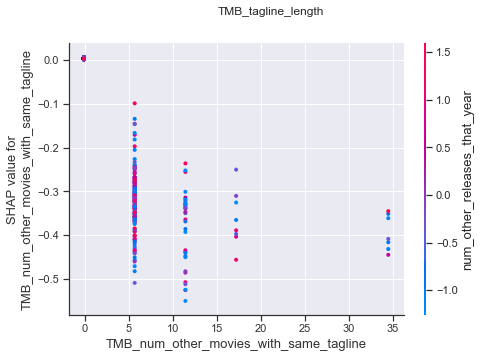

Warning, filename truncated because it was over 30. Filenames may no longer be unique
Warning, filename truncated because it was over 30. Filenames may no longer be unique


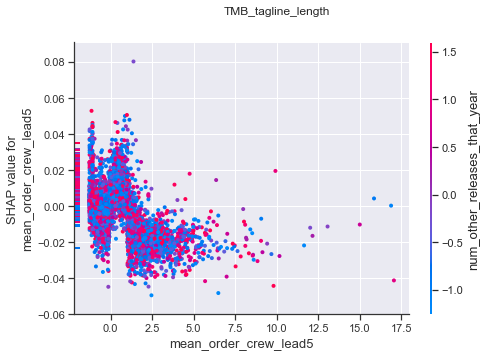

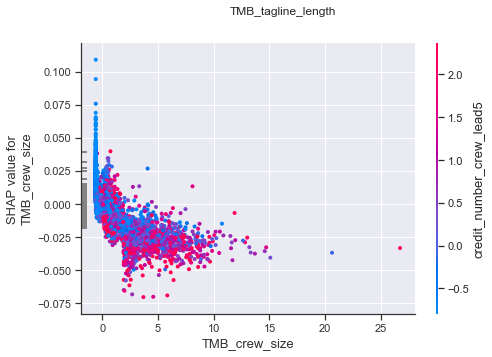

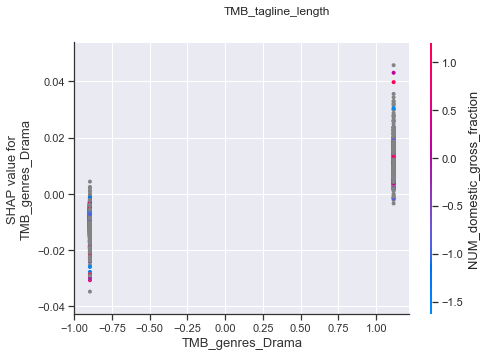

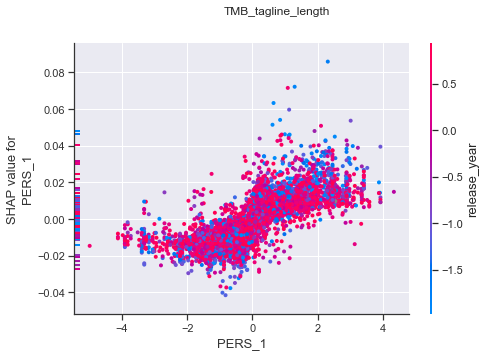

Wall time: 14min 14s


In [319]:
%%time
global BES_output_folder
drop_cols = []
Treatment = "xgboost_numerical_only_with_agg_crew_cast_data_with_fusion_data"

# drop_cols.extend(fused_cols)

# drop_cols.extend(["release_year","gross_normalised",
#                   "TMB_num_other_movies_with_same_homepage"]) # inflation is cheating!
var_name = "TMB_tagline_length"


BES_output_folder= ".."+os.sep+"Output"+os.sep


df = INT_df_ord_only.drop(drop_cols,axis=1).copy()
drop_movies = df[df.isnull().all(axis=1)].index
df.drop(drop_movies,inplace=True)
# standardise data (subtract out the mean, divide through by standard deviation)
df = pd.DataFrame(           StandardScaler().fit_transform(df.values ),
                             columns = df.columns,
                             index   = df.index      )

mask = df[var_name].notnull()
df = df[mask]
colname = var_name
var_stub = var_name
var_list = [var_name]
var_stub_list = [var_stub]

(explainer, shap_values) = xgboost_run(subdir=colname,min_features = min(df.shape[1]-1,20),
           title = colname+"\n\nPredicts Low "+colname+" <---   ---> Predicts High "+colname, dependence_plots=True,
                                       output_folder=BES_output_folder,Treatment=Treatment)
